**Predicting and segmenting census data to classify individuals income levels as below \\$50,000 or above \\$50,000.**

Data was provided by Census Income dataset available at the UC Irvine Machine Learning Repository.

I will start with a visualization of each feature, then work into preprocessing. Next, I will use several different classification methods, and end with analysis and segmentation.

Please note - any time the numbers '0' and '1' are used when referring to classes, classification, or targets, '0' means '<=50k annual salary', and '1' means '>50k annual salary'.

The below imports and methods are used throughout the notebook, so they are defined at the start.

In [1]:
#Imports used for NN
import pandas as pd
import tensorflow as tf
import numpy as np

#Used for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, roc_curve, auc, confusion_matrix

#General use
from collections import defaultdict
import math
import time

In [2]:
#Methods are used through this notebook

#Loads train/test datasets
def load_datasets():
    
    #First row is headers, so just simple import on the csv data using pandas
    train_csv = pd.read_csv("au_train.csv")
    test_csv = pd.read_csv("au_test.csv")

    #Remove period from last character in class for test cases
    test_csv['class'] = test_csv['class'].str.replace('.', '')
    
    return train_csv, test_csv

#Convert object columns to discrete numerical values
def convert_to_discrete(ds):
    for col in ds:
        if ds[col].dtype == np.dtype('object'):
            temp_col = pd.Categorical(ds[col])
            temp_col = temp_col.codes
            ds[col] = temp_col
    
    return ds

## Visualization

I'm starting with an analysis of this dataset's features. This will give us a better understanding of each feature, how it correlates, and later on, data-preprocessing as well as how we should segment.

In [3]:
#Load data
train_csv, test_csv = load_datasets()
ds = pd.concat([train_csv, test_csv], axis=0)

"""
Creates and returns a bar chart
ds - dataset to evaluate
classes - different classes that an item can be categorized as (in this case, <=50k and >50k)
col - what column to look at
x - the x values for the bar chart
xlbl - the label for the x axis
ylbl - the label for the y axis
rotate - whether or not to rotate the x axis tickmarks

Returns:
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
"""
def createBarChart(ds, classes, col, x, xlbl, ylbl, rotate=0):
    y = []
    for i in x:
        data = []
        for cls in classes:
            temp = ds.loc[(col == i) & (ds['class'] == cls)]
            data.append(temp.size)
        y.append(data)
    
    y0 = [i[0] for i in y]
    y1 = [i[1] for i in y]
    
    width = 0.5
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y0, width, color='g', label='<=50k')
    ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
    if rotate > 0:
        ax.set_xticklabels(x, rotation=rotate)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.legend()
    ax.set_title("{} vs annual salary".format(col.name.capitalize()))
    plt.show()
    
    return y0, y1

"""
Creates and returns a bar chart for continuous data using a range (start, stop, step)
ds - dataset to evaluate
classes - different classes that an item can be categorized as (in this case, <=50k and >50k)
col - what column to look at
start - what number to start at
stop - what number to stop at
step - how large should each step be
xlbl - the label for the x axis
ylbl - the label for the y axis
width - width of each bar on graph (default is 0.5)

Returns:
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
"""
def createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=0.5):
    y=[]
    
    for i in range(start, stop, step):
        data = []
        for cls in classes:
            temp = ds.loc[(col.between(i, i+step)) & (ds['class'] == cls)]
            data.append(len(temp.index))
        y.append(data)

    x = list(range(start, stop, step))
    y0 = [i[0] for i in y]
    y1 = [i[1] for i in y]

    width = width
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y0, width, color='g', label='<=50k')
    ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
    
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.legend()
    ax.set_title("{} vs annual salary".format(col.name.capitalize()))
    plt.show()
    
    return y0, y1

"""
Creates and returns a table that displays percentages
title - title of the column focused on
x - x values that were used for bar chart
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
max - the stopping point for range of splits for continuous feature

Returns:
x_disp - x values that had corresponding y values (not 0) and were shown
y0_p - Percent of items belonging to class <=50k
y1_p - Percent of items belonging to class >50k
"""
def createTable(title, x, y0, y1, max=0):
    y0_p = []
    y1_p  = []
    x_disp = []
    for i in range(len(y0)):
        if y0[i] > 0 or y1[i] > 0:
            y0_p.append((y0[i]/(y0[i]+y1[i]))*100)
            y1_p.append((y1[i]/(y0[i]+y1[i]))*100)
            if i < len(x):
                x_disp.append(x[i])
            else:
                x_disp.append('>= {}'.format(max))
        else:
            pass
            
    table_data = []
    for i in range(len(x_disp)):
        table_data.append([x_disp[i], y0_p[i], y1_p[i]])

    cols = [title, '% <=50k', '% >50k']
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1,1,1)
    table = ax.table(cellText=table_data, colLabels = cols, loc='center')
    table.set_fontsize(14)
    table.scale(1,2)
    ax.axis('off')
    plt.show()
    
    return x_disp, y0_p, y1_p

"""
Creates and returns a table that displays percentages
title - title of the column focused on
x - x values that will be used
y0_p - Percent of items belonging to class <=50k
y1_p - Percent of items belonging to class >50k
xlbl - the label for the x axis
ylbl - the label for the y axis
rotate - whether or not to rotate the x axis tickmarks

Returns:
None
"""
def showScatter(title, x, y0_p, y1_p, xlbl, rotate=0):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, y0_p, label='<=50k')
    ax.scatter(x, y0_p)
    ax.plot(x, y1_p, label='>50k')
    ax.scatter(x, y1_p)
    if rotate > 0:
        ax.set_xticklabels(x, rotation=rotate)
    ax.set_title("{} vs annual salary".format(title))
    ax.set_xlabel(xlbl)
    ax.set_ylabel('% of category')
    ax.legend()
    plt.show()

In [4]:
#These will be used for each feature
temp_col = pd.Categorical(ds['class'])
temp_col = temp_col.codes
ds['class'] = temp_col
classes = ds['class'].unique()
ylbl = '# of people'

### Age
#### Bar Chart
From the bar chart, we can see there is a trend of ages where the number of people in the >50k class grows, from what looks like the ages of 28-65. This would suggest a correlation between age and salary

#### Table
The table gives more evidence to this correlation, showing that as age increases, so does likelihood of being in >50k class. After age 27, almost no ages drop to less than 10% making >50k. Ages 31-69 have >=20% that are in that class, and ages 37-61 have all but one where >=30% make >50k.

### Scatterplot
The scatterplot of each percentage shows a quadratic trend to age vs salary, displaying the ages discussed in the table section and how middle-aged people are more likely to be in the >50k category.

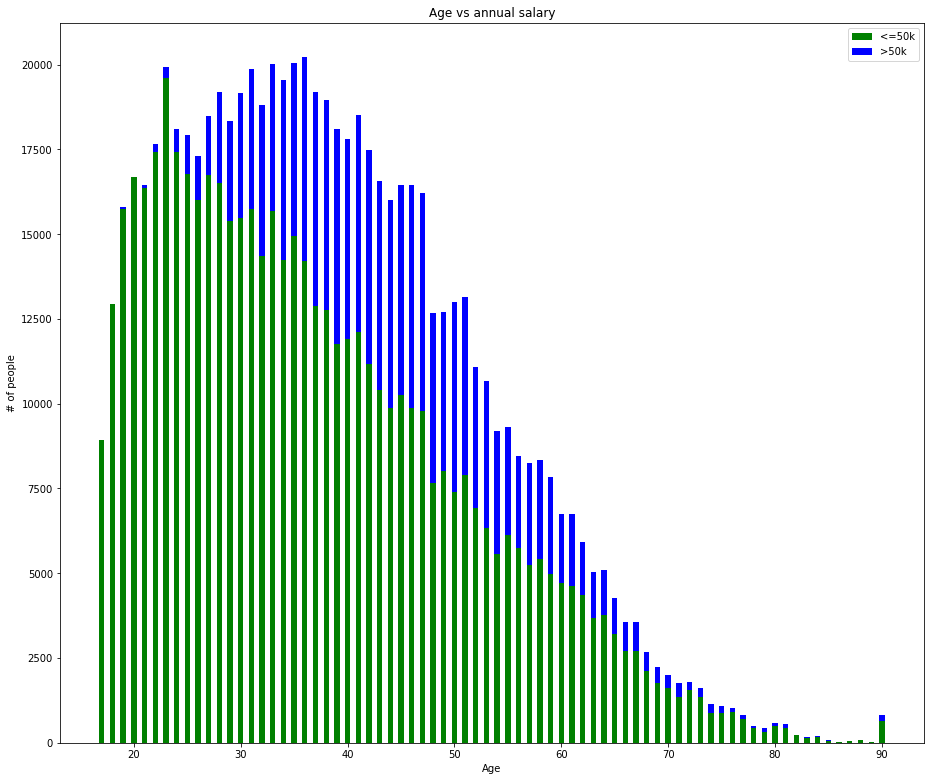

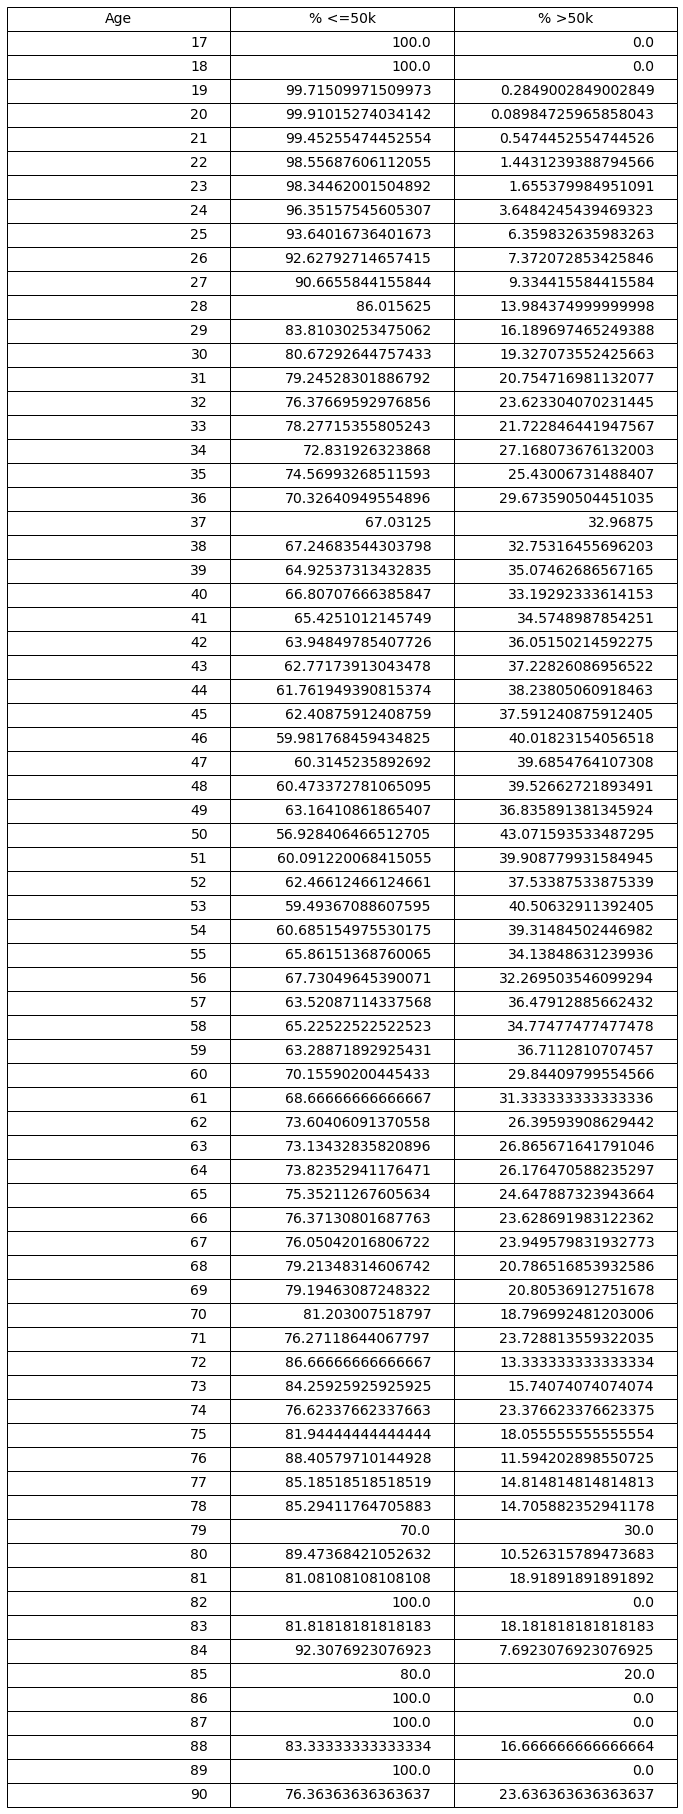

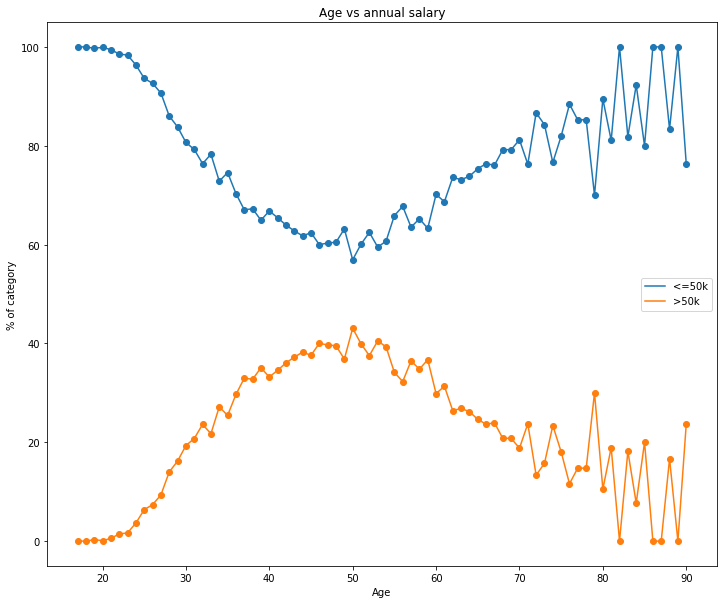

In [5]:
col = ds['age']
x = col.unique()
x.sort()

xlbl = col.name.capitalize()
y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
showScatter(xlbl, x, y0_p, y1_p, xlbl)

### Workclass
#### Bar Chart
The bar chart shows us that  almost all categories have noticable portions in the >50k class, all except unknown (?), without-pay, and never worked. Without pay had less than 20 people fitting this category, and it would make sense that most people without pay would make >50k annually.
#### Table
The table does confirm that most categories do well; however, there are some workclasses that do better than others. self-emp-inc are people who work for thesmelves in corporate entities. This workclass has an actual majority making >50k, with 55% fitting this.

<ipython-input-3-a5b821a2f71f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


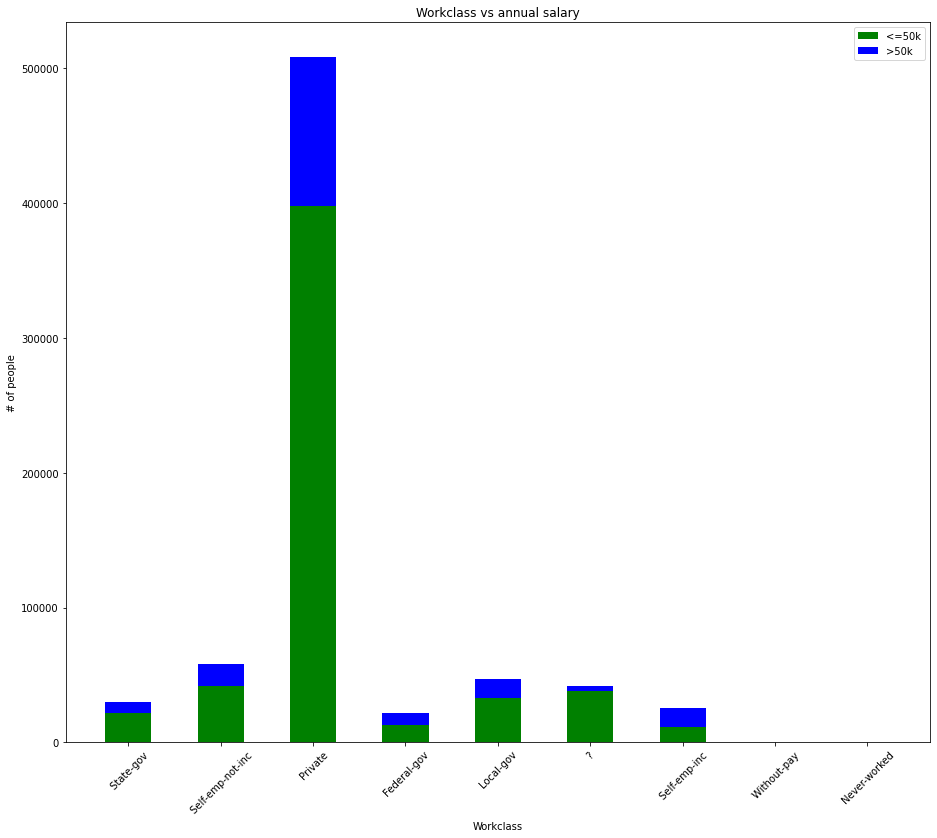

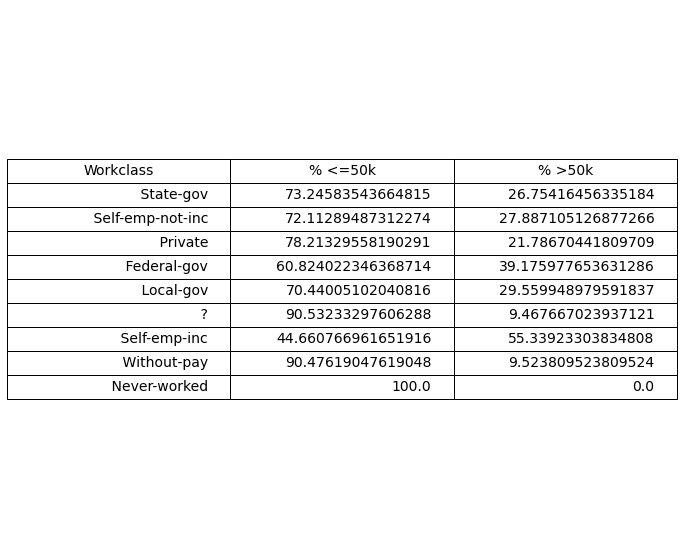

In [6]:
col = ds['workclass']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(col.name.capitalize(), x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl)

### Fnlwgt
#### Bar Chart
Fnlwgt appears to have a similar quadratic trend to age, suggesting that fnlwgt is a noticable factor for determining class. The dropoff for # of people for each fnlwgt category drops off rather quickly, so this may be a reason why this quadratic curve exists - rather than correlation, this could be just causation.
#### Table
The table shows that, rather than a quadratic fit for percentages, there is actually a relatively linear fit with some noise. Most splits for this column have a 75-25 split for each class, which is similar to what the actual data is (roughly 75% are in the <=50k class, and roughly 25% are in the >50k class).

#### Scatterplot
The scatterplot visualizes this linear trend for us, showing a general updward curve in percent of people in the >50k class. However, in the first few splits, each value is relatively close to what it's neighbors are at, but as the splits increase, there is more deviation - the greater splits follow the 75-25 curve less, some with more and some with less in the >50k class.

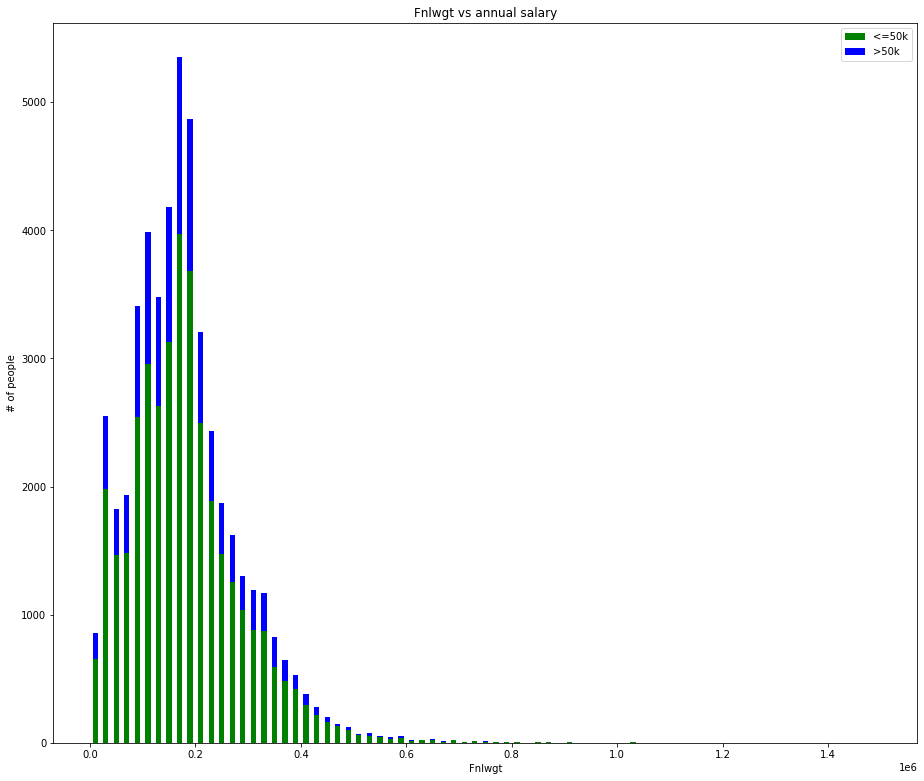

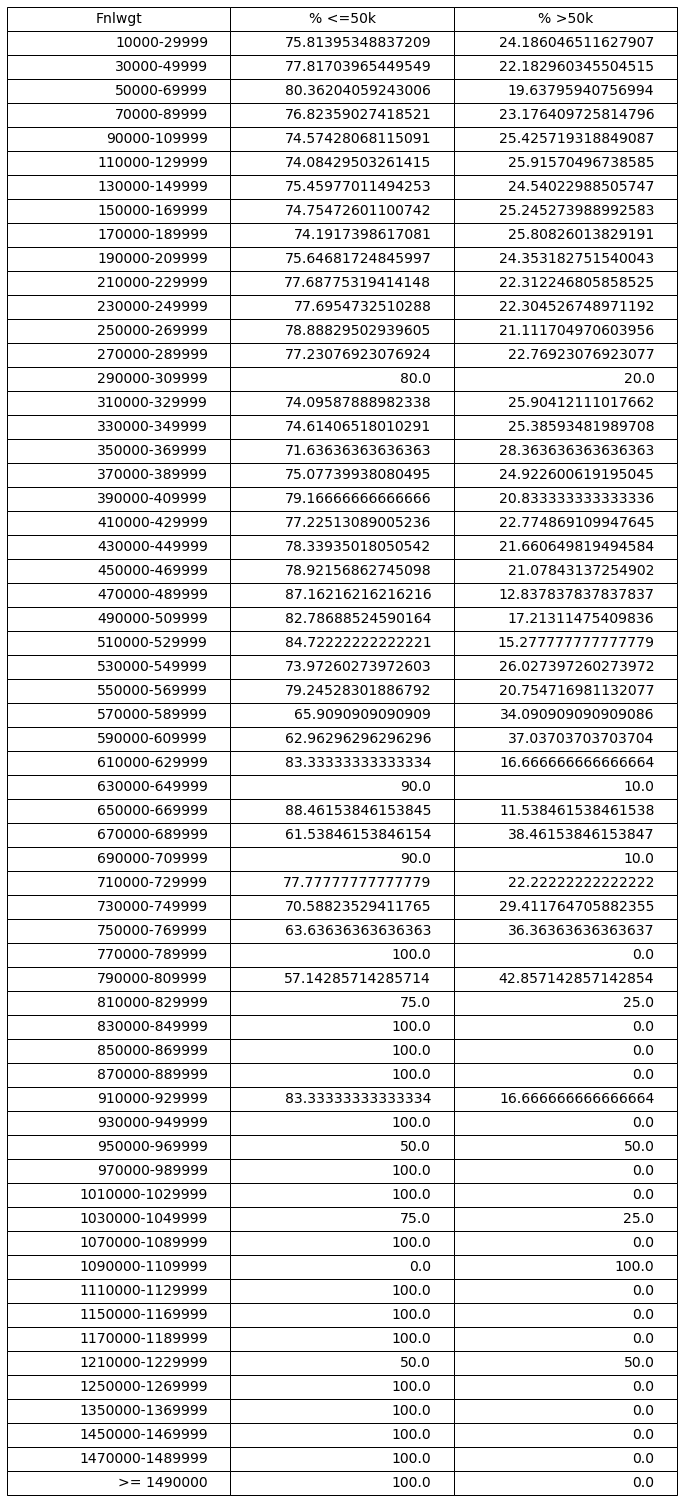

<ipython-input-3-a5b821a2f71f>:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


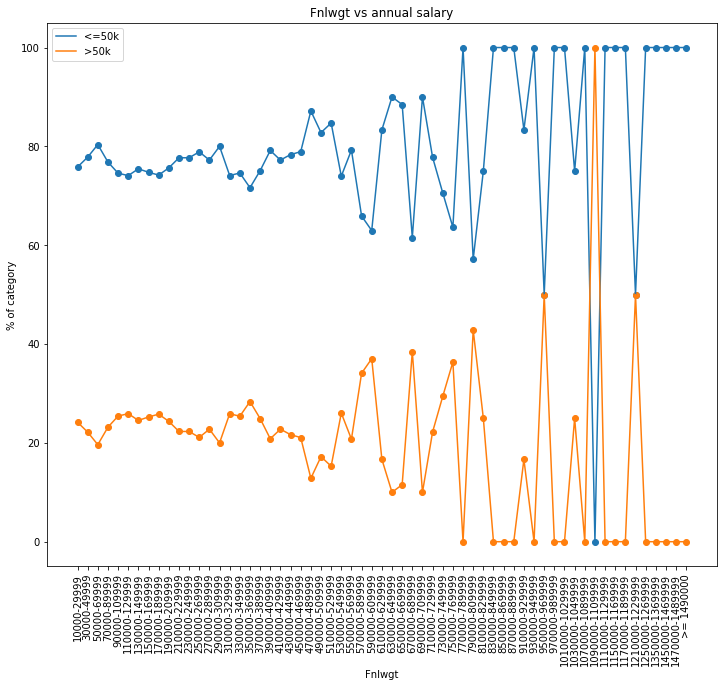

In [7]:
col = ds['fnlwgt']
start=10000
stop=1500000
step=20000
xlbl = col.name.capitalize()

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, 10000)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))

x, y0_p, y1_p = createTable(xlbl, x, y0, y1, max=1490000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, 90)

### Education
#### Bar Chart
The graph shows clear differences in proportions for each education category, with some having very few people in the >50k category, and some educations having a majority. It appears that the higher the education, the higher the percent making >50k annually.
#### Table
The percentages reinforce this theory that higher education correlates to greater salary - All levels below high-school grad have <10% making >50k. However, HS grad has nearly 16%, bachelors have a great increase at 41%, 3x as many as high school grad. Moving upward, Masters have 54%, and Doctorates have over 70% each. Furthermore, Assoc-acdm and Assoc-voc have ~25% each, and Prof school matches the doctorate at 70% making >50k.


<ipython-input-3-a5b821a2f71f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


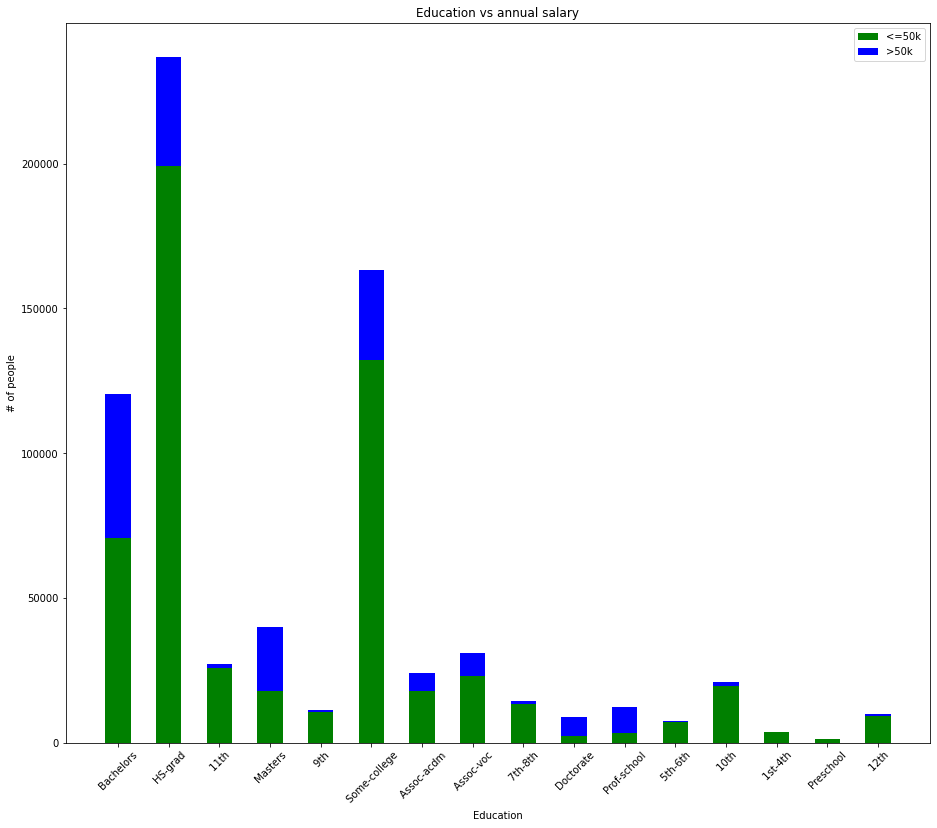

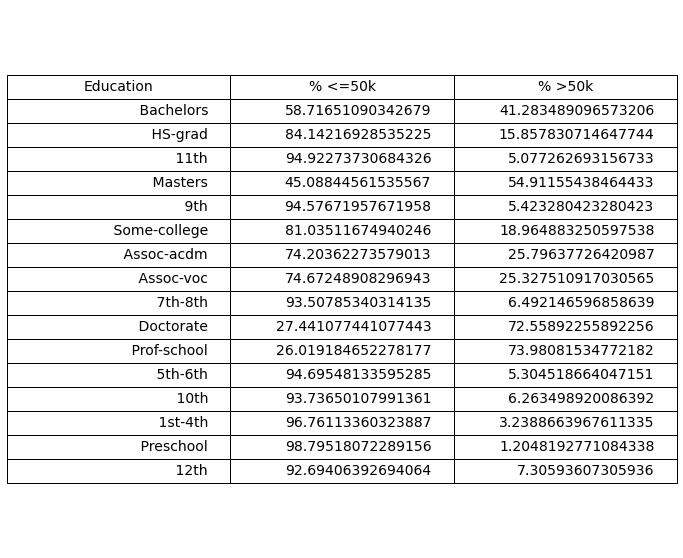

In [8]:
col = ds['education']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, 45)

### Marital-status
#### Bar Chart
Most categories for marital status are dominantly <=50k. There are only 2 categories that do exceptionally well - married-civ-spouse, and married-af-spouse. However, married-af-spouse has very few samples, so this may be innaccurate.
#### Table
The table for marital status shows that, indeed, married individuals do exceptionally better than those who aren't. Married civilian spouses have just under 45% making >50k annually, and armed-forces spouses are at ~37% in the same category.

<ipython-input-3-a5b821a2f71f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


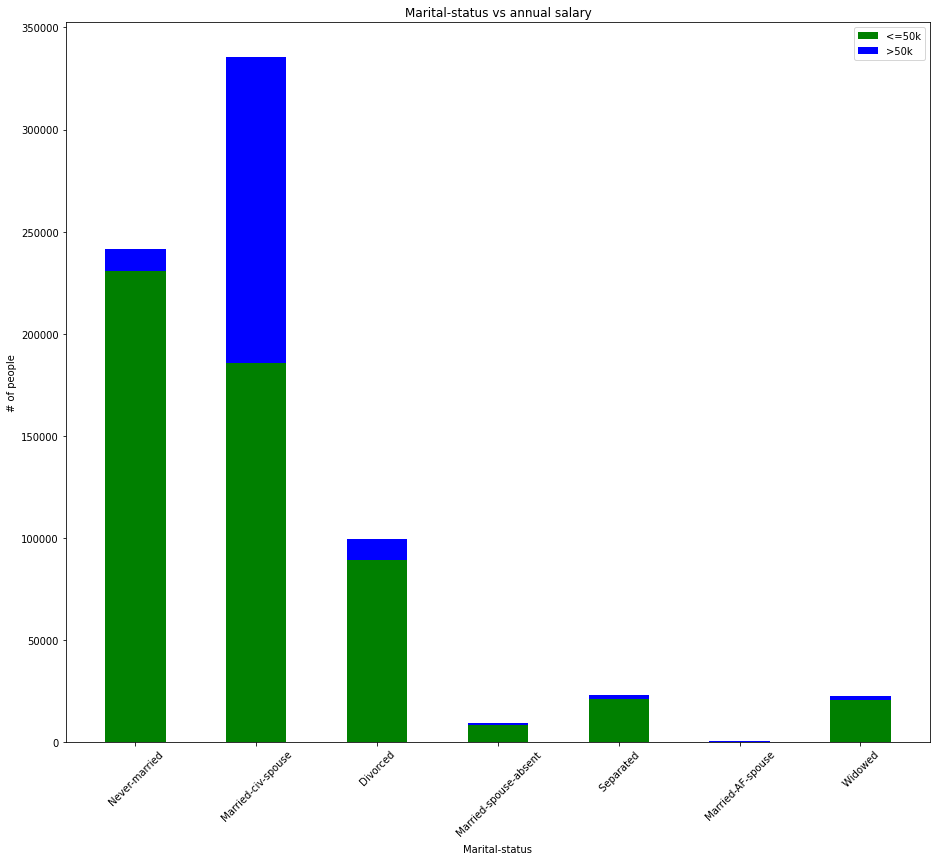

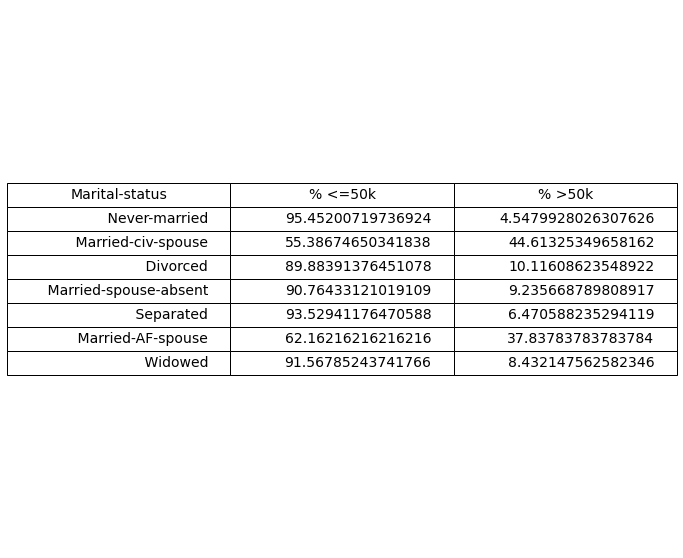

In [9]:
col = ds['marital-status']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, 45)

### Occupation
#### Bar Chart
Again, we see several categories that are mostly <=50k, but some that are a more even split. This would be expected of occupation, the source of income. Executive/managerial, professional/specialty, sales, and craft repair all seem to have noticable chunks in the >50k class.
#### Table
Exec-manageral performs the best with nearly 48% making >50k annually. Prof-speciality does nearly the same at 47%. Armed forces comes in 3rd at 33%, but again, this may be inaccurate as the small sample size. Protective-services follows up with 31%, which has a significantly large sample than armed forces.

<ipython-input-3-a5b821a2f71f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


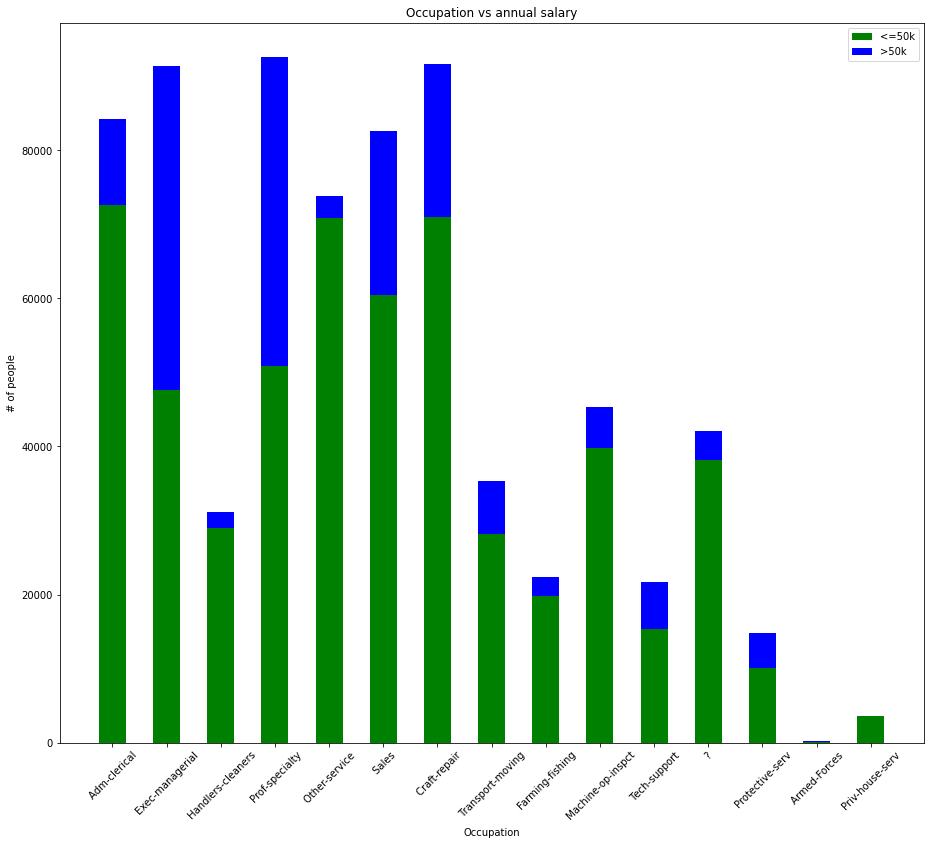

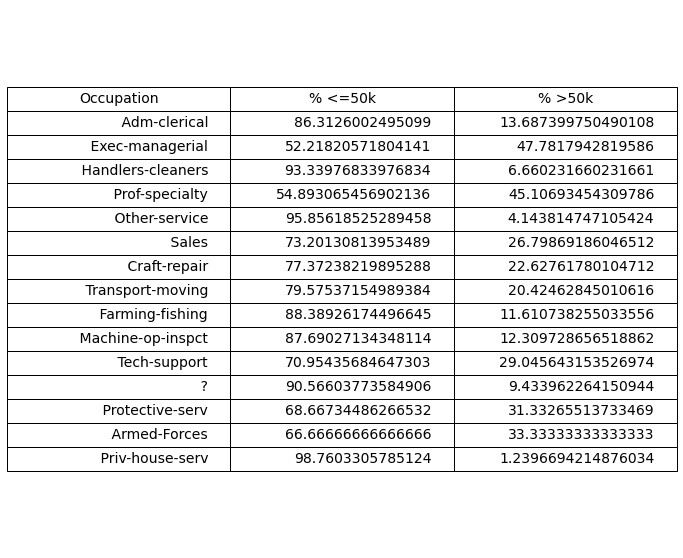

In [10]:
col = ds['occupation']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, 45)

### Relationship
#### Bar Chart
This chart is closely linked to the marital-status column - only the husband and wife categories have majorities making >50k annually. The rest have significantly fewer.
#### Table
Husband and wife, as shown, display the best results - however, wife actually has 46%, whereas husband has 44%. This is different than what the "sex" column will show later on, with women having a significantly smaller percentage making >50k.

<ipython-input-3-a5b821a2f71f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


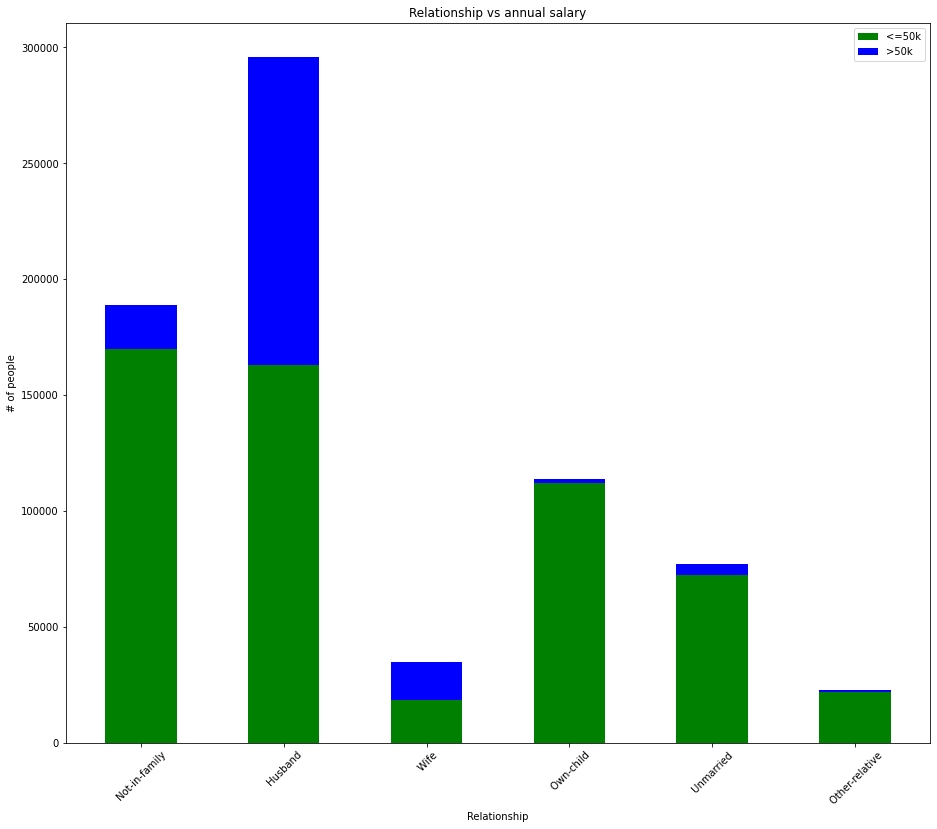

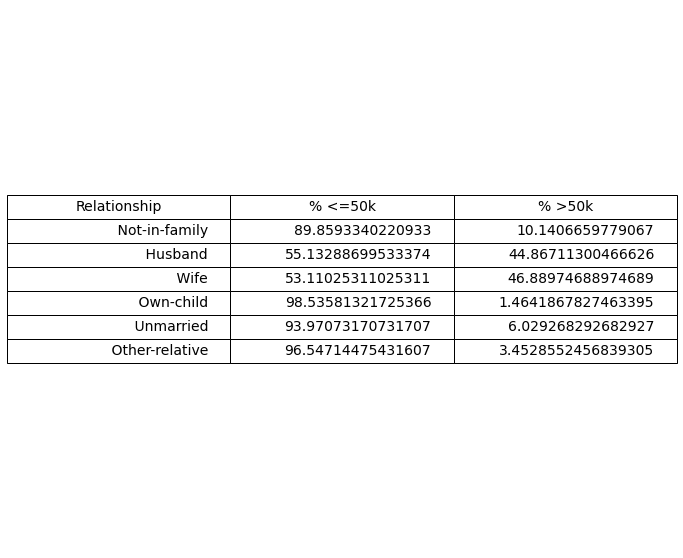

In [11]:
col = ds['relationship']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, 45)

### Race
#### Bar Chart
Here we can actually see a negative correlation - only white and pacific highlander seem to have a percentage of standard size making >50k. The rest have smaller percentages, showing that race could lead to a smaller salary. 
#### Table
As discussed, only white and pacific highlander have reasonable percentages. In fact, they follow the trend of the data presented, with 75% making <=50k, and 25% making >50k. The other races have smaller than 25% making >50k, in fact by half as much - black, amer-indian-eskimo, and other all have 11-12% in the >50k class.

<ipython-input-3-a5b821a2f71f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


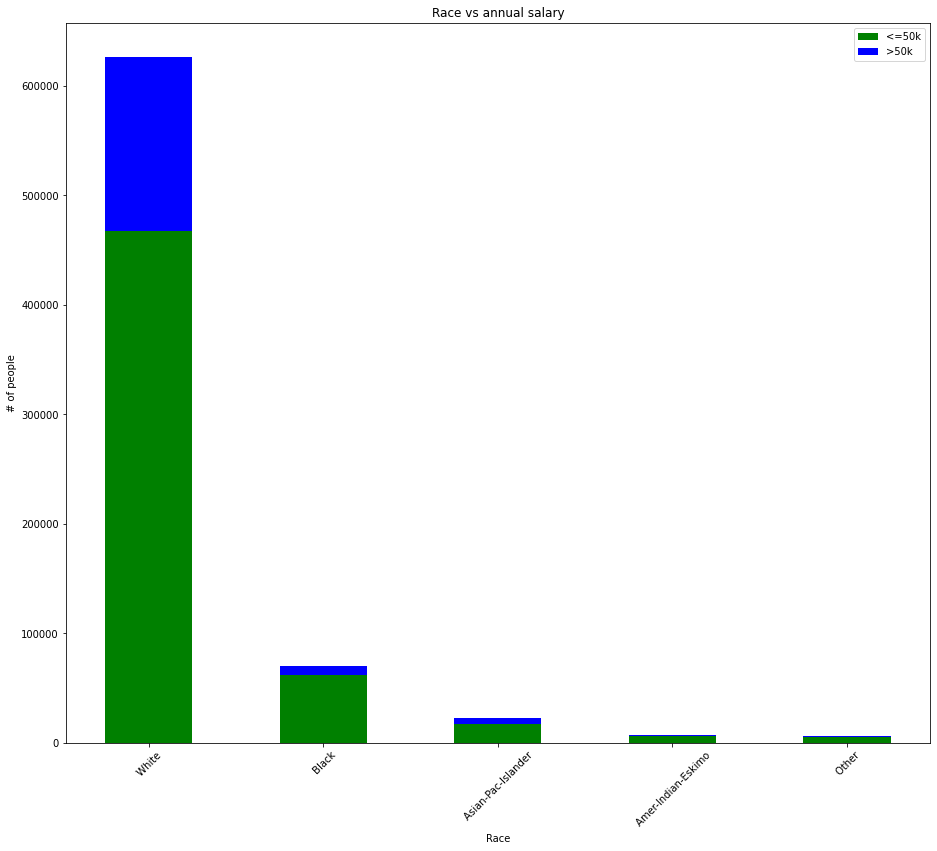

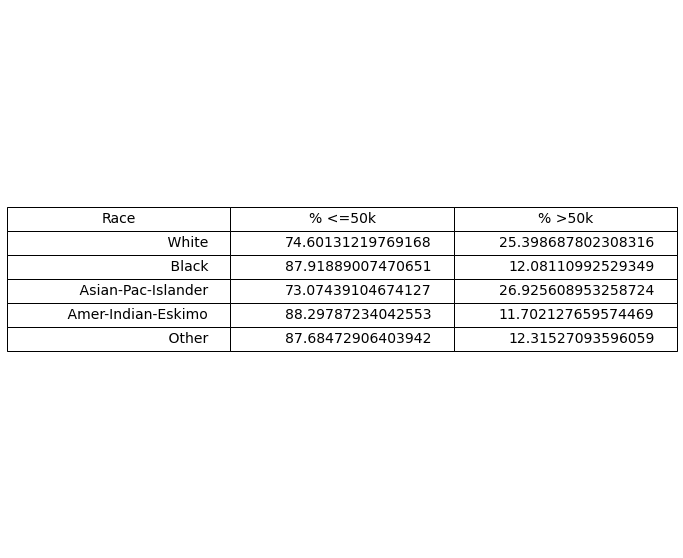

In [12]:
col = ds['race']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, 45)

### Sex
#### Bar Chart
From the earlier relationship column, we see husbands and wives with nearly the same percentage making >50k. Here, however, we see that men have a significantly higher percentage in this category.
#### Table
Again, men do, in fact, have a greater percentage making >50k - 20% more than women. In fact, men even have a greater percentage than the ~75-25 trend the data follows, while women have significantly less.

<ipython-input-3-a5b821a2f71f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


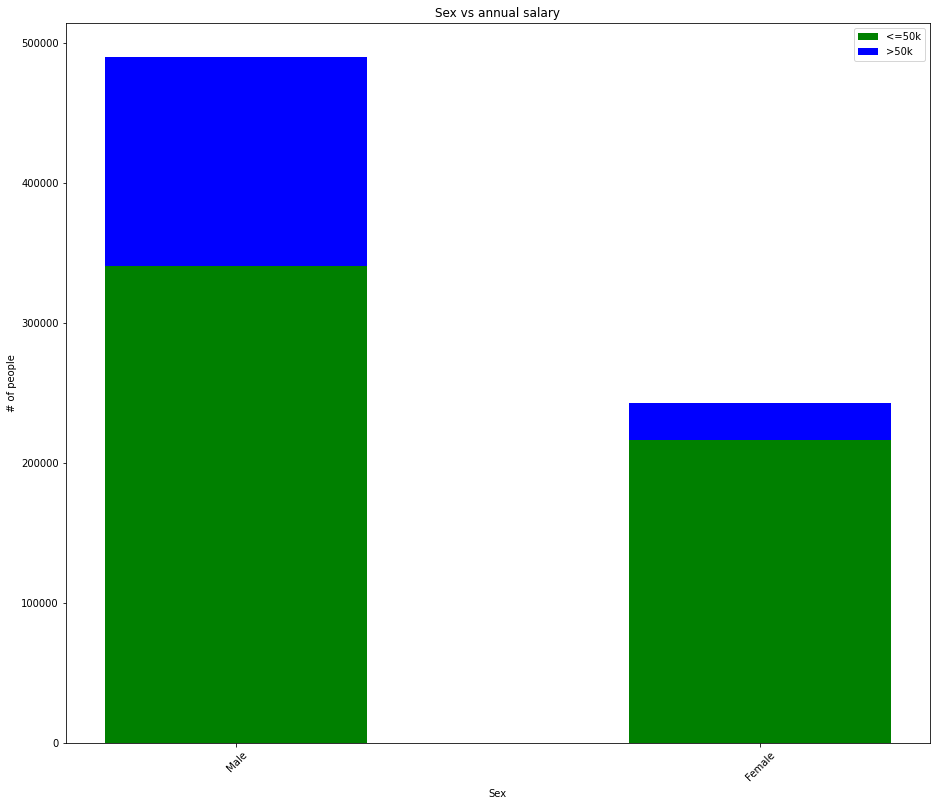

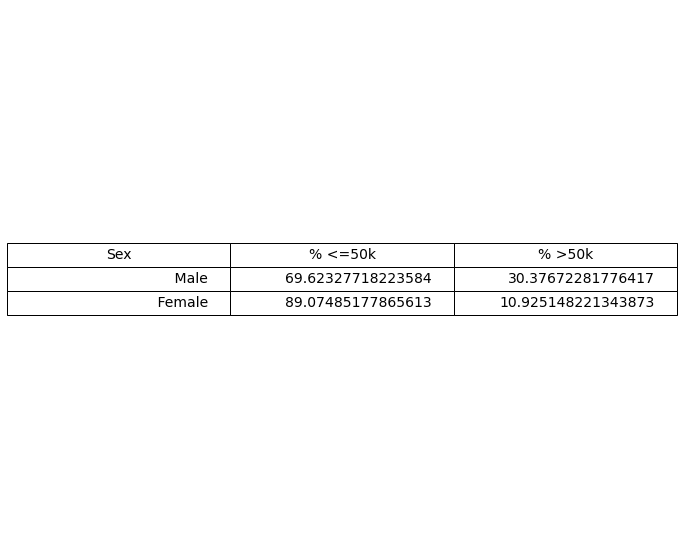

In [13]:
col = ds['sex']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)

### Capital-gain
#### Bar Chart
Almost everyone in this study had <20,000 for capital gain. From everyone between 0 and 20,000, almost everyone there had 0 capital gain. However, there were a few people making nearly 100,000 in capital gain, and everyone in this category is in the >50k class.
#### Table
Looking at each split under 11,000, there are some splits that extremely favor those who make >50k. Given more data, we could assume a certain salary looking at these splits. Furthermore, looking at the few who have a capital-gain of nearly 100,000 and how it is 100% people in the >50k class, we could make connections with their salaries given more information there as well.
#### Scatterplot
The scatterplot paints the story told in the table - for captain gain under 5000, this is mostly people making <=50k. From 5,000-6,000, this is a fairly even split, then 6,000-7,000, this again favors <=50k salaries. However, capital gain from 7,000 to 20,000 is almost always 100% salaries >50k. There are some splits after 20,000 that switch back and forth, but the highest capital gain is, again, >50k.

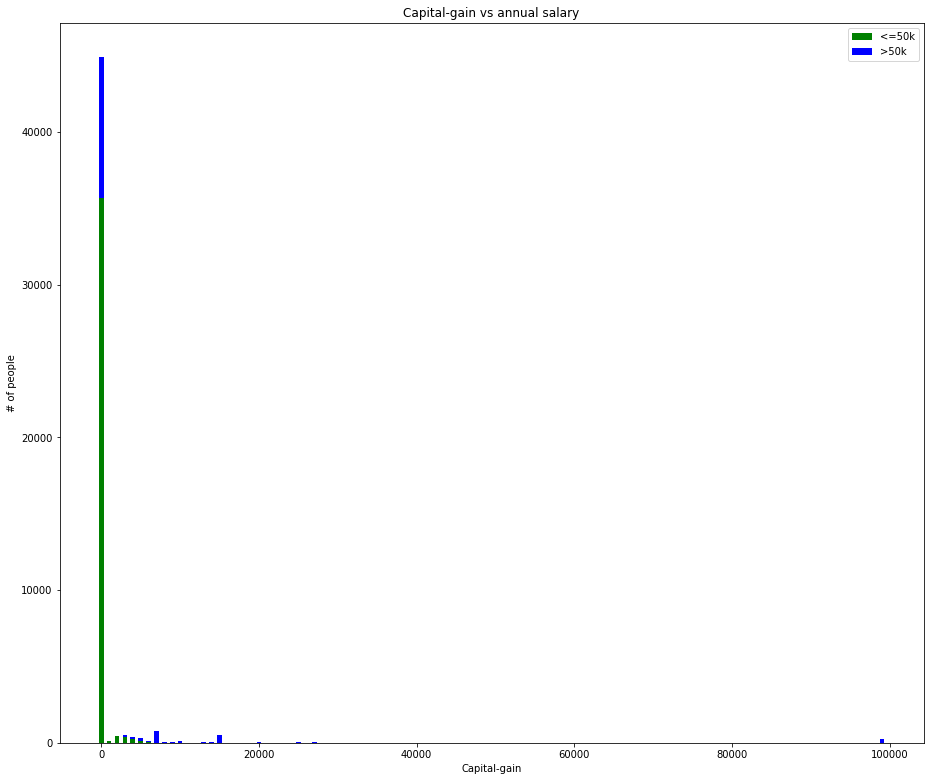

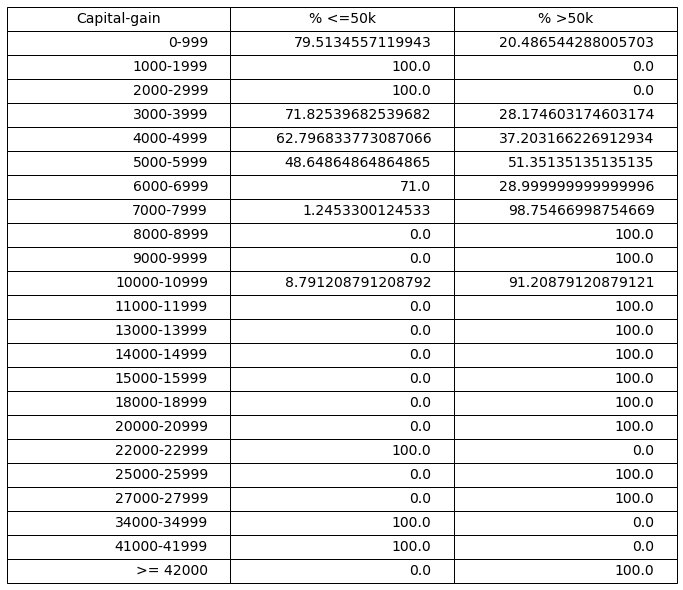

<ipython-input-3-a5b821a2f71f>:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


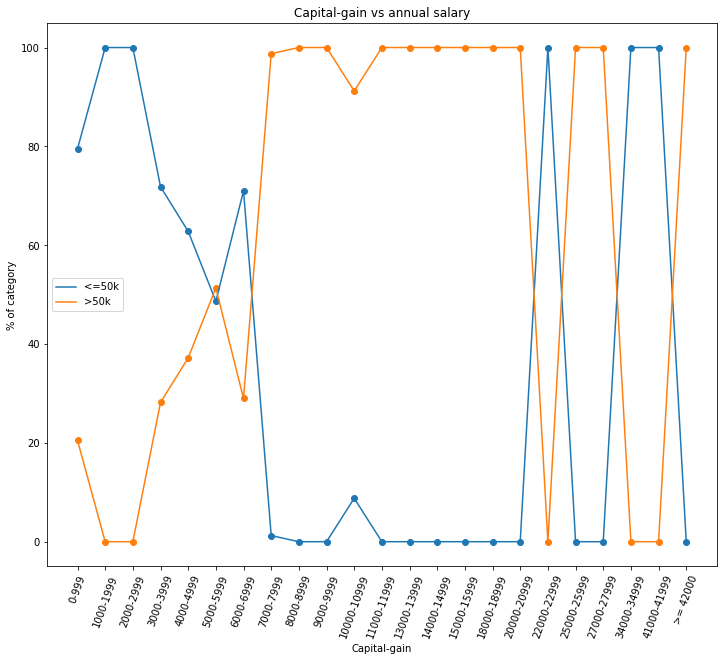

In [14]:
col = ds['capital-gain']
xlbl = col.name.capitalize()

start=0
stop=100000
step=1000

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=600)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))
x, y0_p, y1_p = createTable(xlbl, x, y0, y1, 42000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, 70)


### Capital-loss
#### Bar Chart
The bar chart shows, similar to capital gain, most people had 0 capital loss. After 0, there are some samples spread out, but the numbers at 0 capital loss follow the 75-25 trend of the data.
#### Table
The data doesn't show us any obvious trends or correlations, but it does suggest that certain splits favor a group more than other splits. While correlation may not be obvious, it does show it is related in some way.
#### Scatterplot
The scatterplot reinforces the table, not necessarily showing any obvious correlations - the percentages seem to flip-flop in favoritism toward each class.

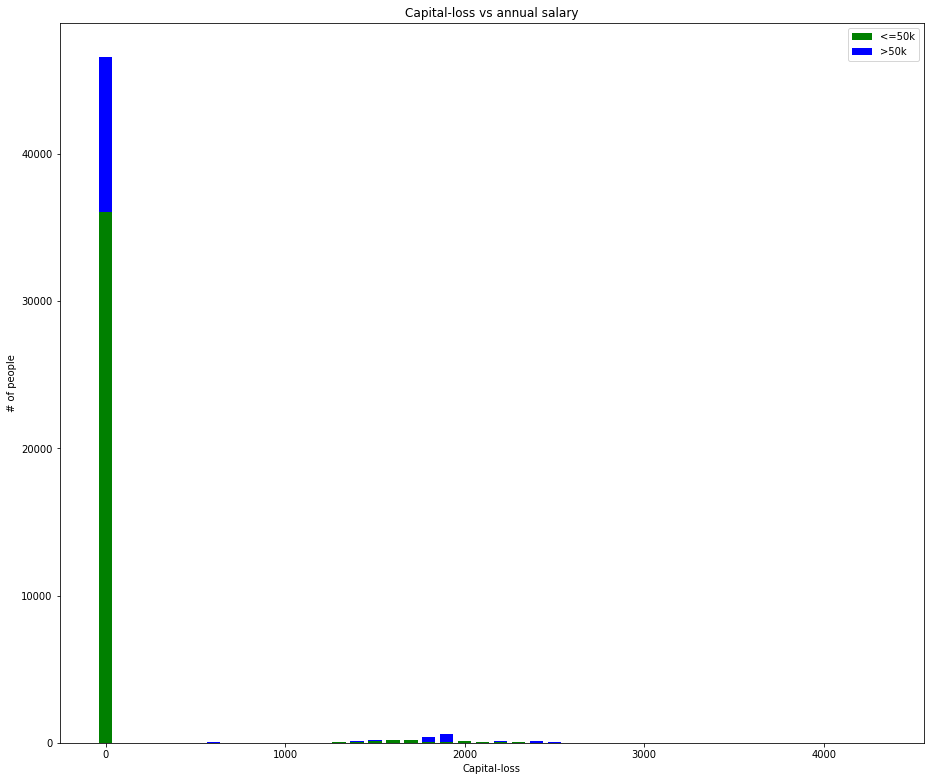

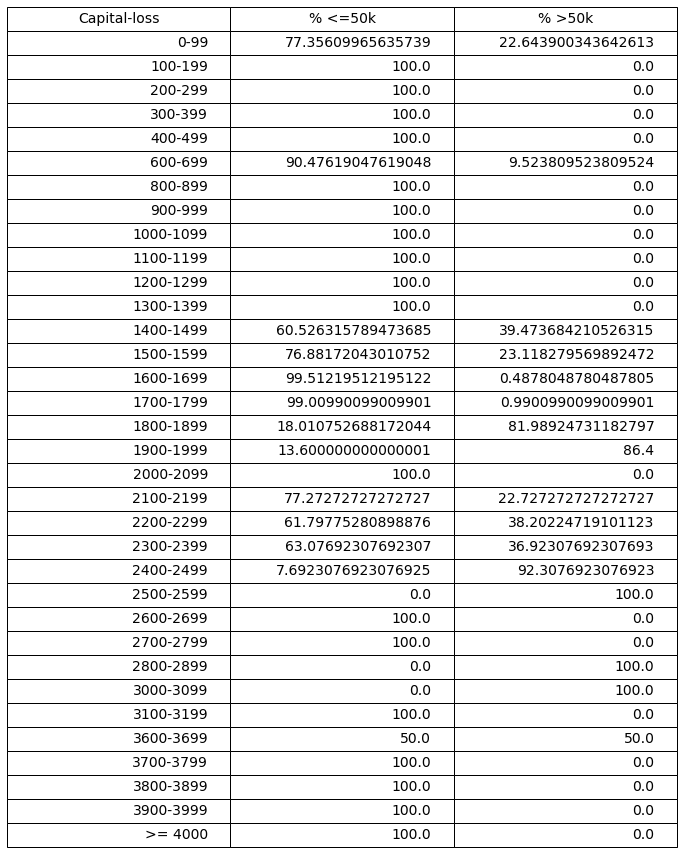

<ipython-input-3-a5b821a2f71f>:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


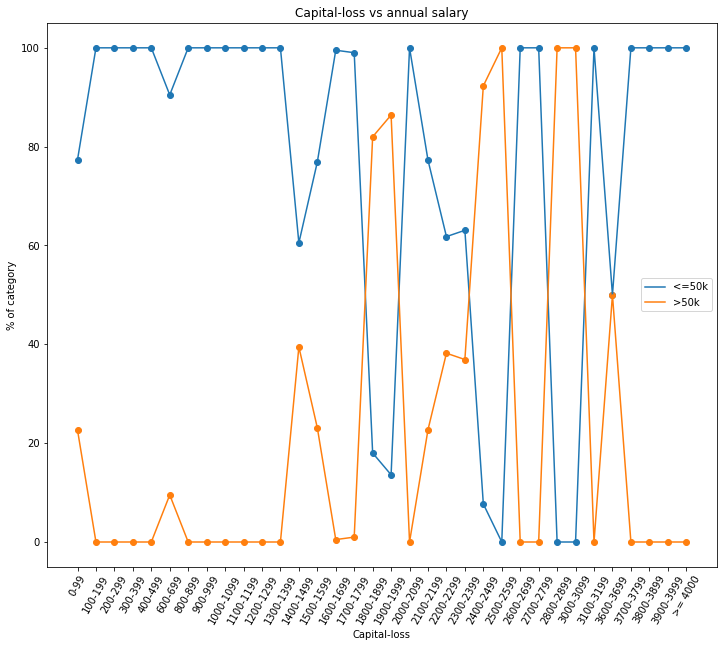

In [15]:
col = ds['capital-loss']
xlbl = col.name.capitalize()

start=0
stop=4400
step=100

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=75)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))
x, y0_p, y1_p = createTable(xlbl, x, y0, y1, 4000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, 60)

### Hours-per-week
#### Bar Chart
The graph here shows that most people work an average of 40 hours per week. There are some larger samples at multiples of 5, such as 20, 30, 35, 45, 50, and 60. There is an interesting trend - under 35 hours per week, a very small portion of each group is in the >50k class. This is likely due to working few hours per week, likely as part-time.
#### Table
The table here shows a steady increase in percent of each group making >50k, with 41 hours/week holding 25% in the >50k class. From there, the trend continues steadily upward to greater percentages making >50k, although the more hours worked per week, the more variance and noise there is - higher hours doesn't guarantee making >50k.
#### Scatterplot
Here we can see that general trend upward for increase in percentage of people making >50k, and we can also see that variance. Percent of people per split making >50k increases quickly from 15 to ~45, then from there it appears to not be as correlated, with the scatterplot showing less of a trend.

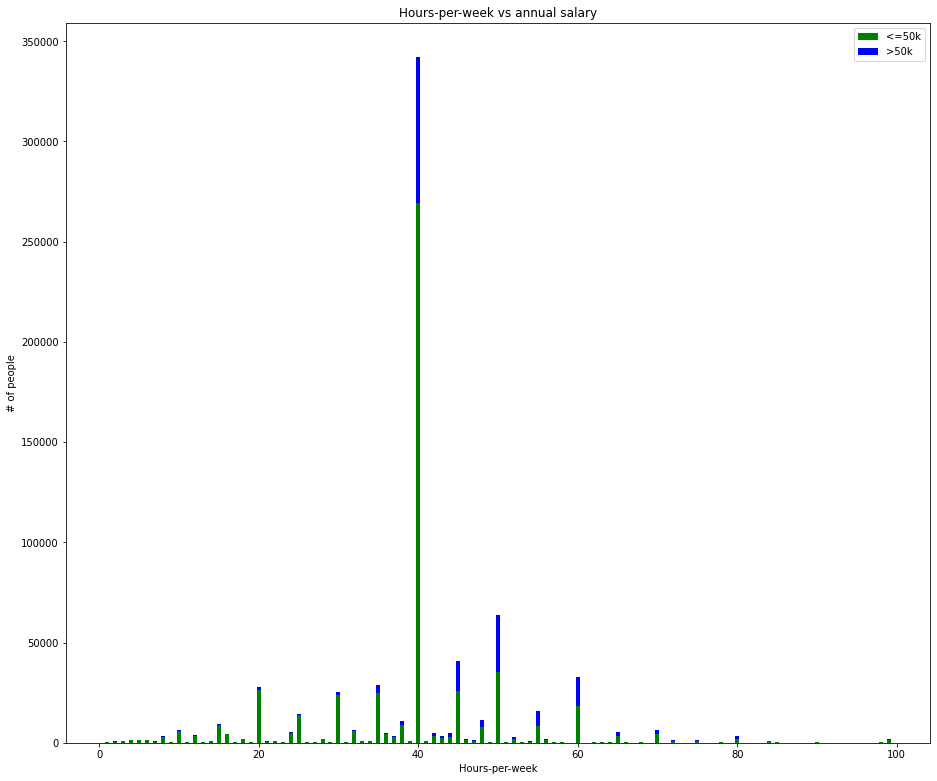

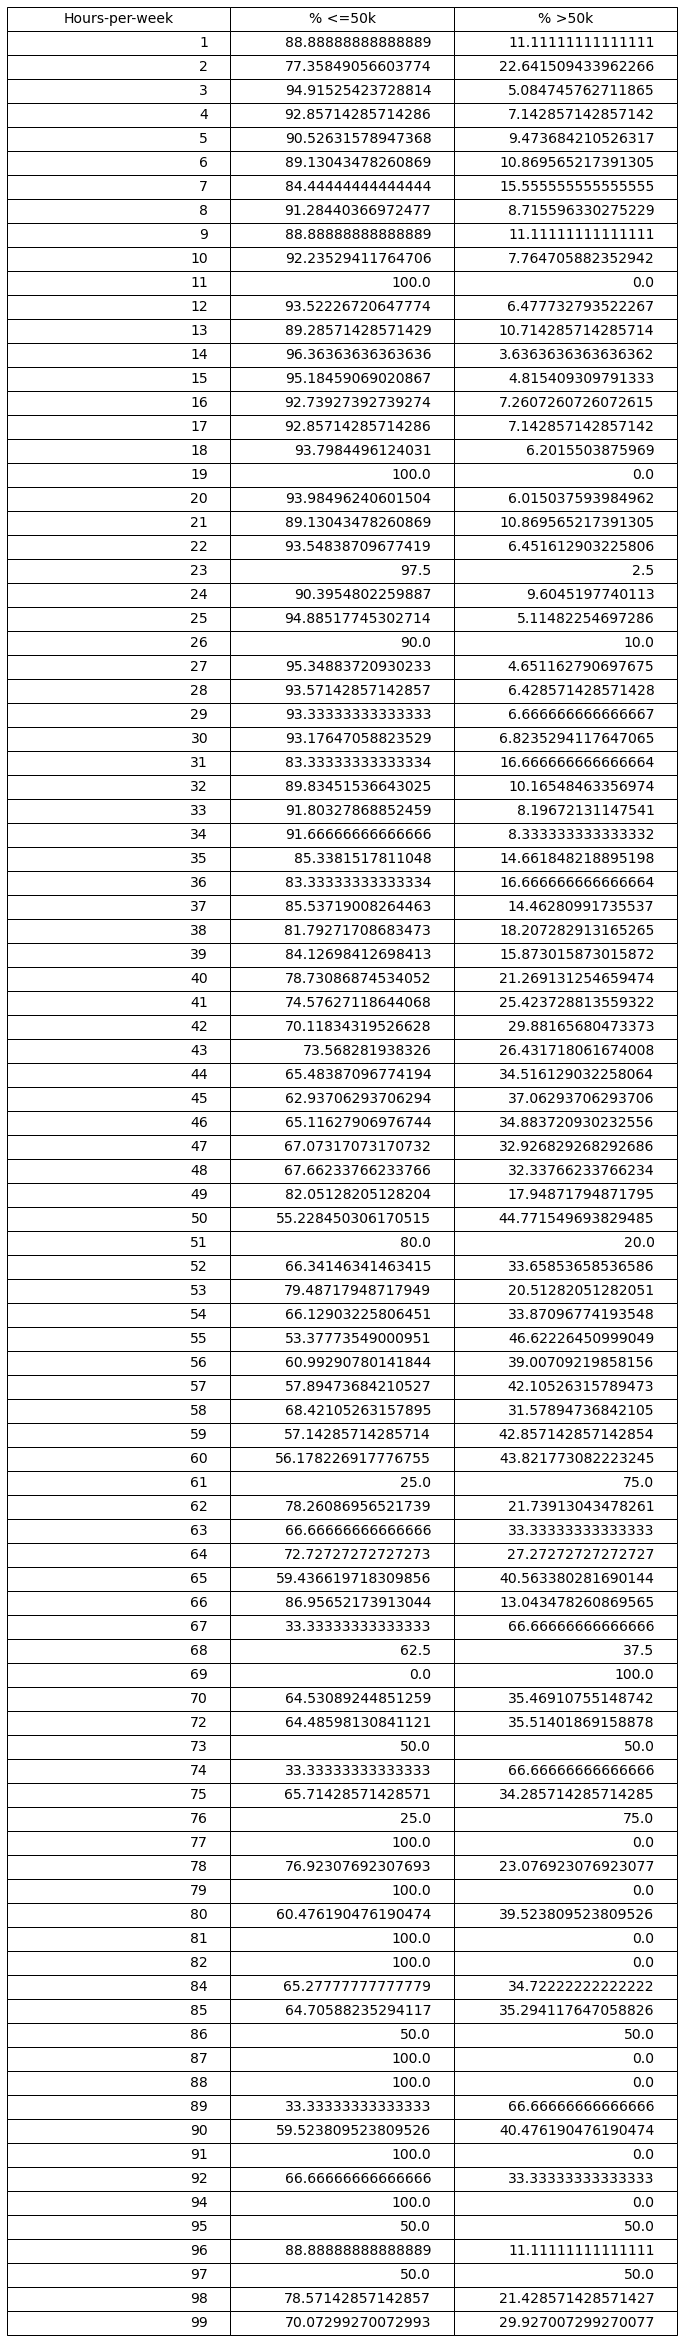

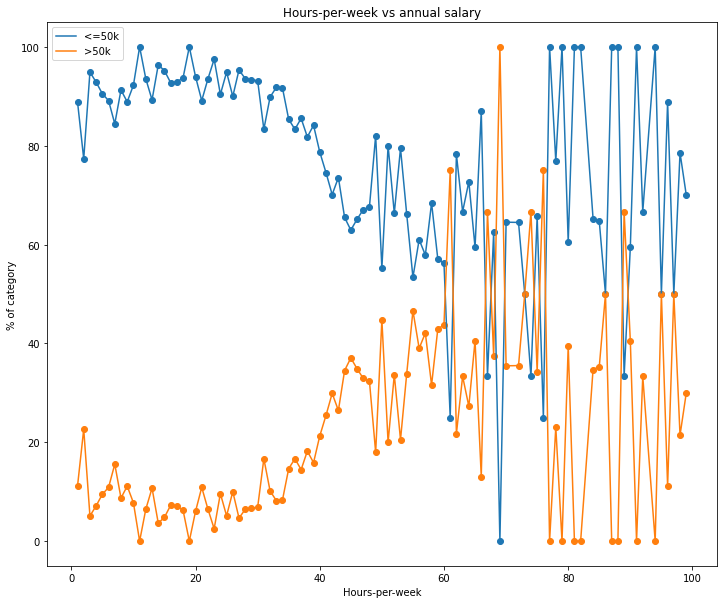

In [16]:
col = ds['hours-per-week']
x = col.unique()
x.sort()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
showScatter(xlbl, x, y0_p, y1_p, xlbl)

### Native country
#### Bar Chart
For the united states, there appears to be no correlation. However, for some native countries such as Mexico and India, the percentage of each class is askew, with Mexico having significantly less than what the data shows overall, and India having a higher percentage. There are significantly fewer samples for these native countries, so this could be a biased sample.
#### Table
The table shows many countries having a variance for percentages from what the data holds. Most countries other than the United States have very few samples overall. Because of this, these results could be misleading.

<ipython-input-3-a5b821a2f71f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=rotate)


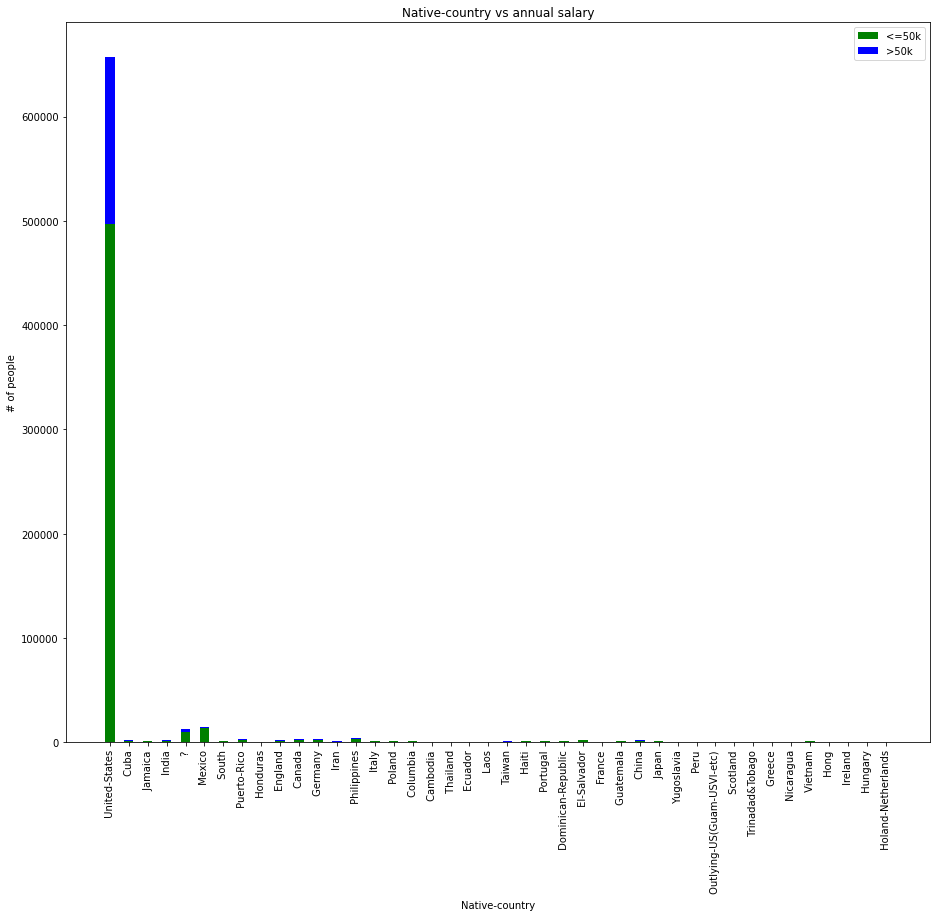

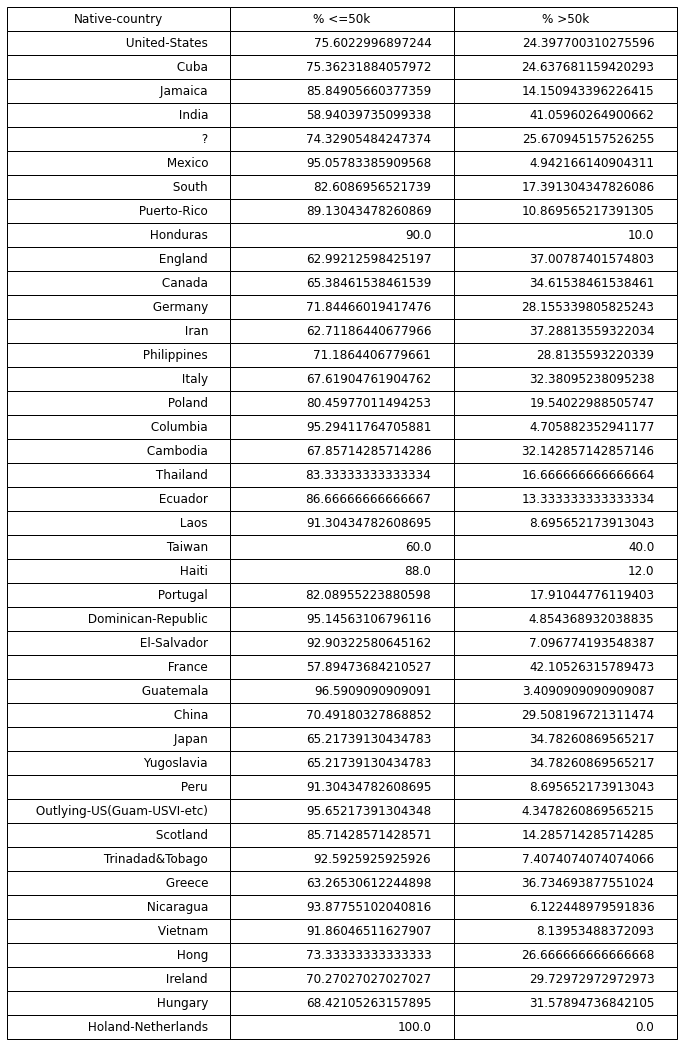

In [17]:
col = ds['native-country']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 90)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, 90)

## Chi-square-test
Now that we've seen the visualizations of each feature, let's look at how strongly the categorical data is linked to classification using a chi square test.

In [18]:
#Gets the counts of each item for a given column
def get_object_data(ds):
    #Get # of rows in dataset
    total = len(ds)
    feature_probs = {}
    
    for col in ds:
        
        #Don't want to count target col
        if col == 'class':
            continue

        #If column is object, count each item and divide by # of rows
        elif ds[col].dtype == np.dtype('object'):
            feature_probs[col] = ds[col].value_counts().to_dict()

    return feature_probs

In [19]:
from scipy.stats import chi2_contingency 
train_csv, test_csv = load_datasets()
ds = pd.concat([train_csv, test_csv], axis=0)

#Load counts of each subitem for each column in each class
feature_class_counts = {}
classes = train_csv['class'].unique()
for k in classes:
    #Just get the rows belonging to the specific class
    current_class = ds.loc[ds['class'] == k]
    feature_class_counts[k] = get_object_data(current_class)

#Loop through obj columns for each class, get the chi2 and p values
obj_cols = list(feature_class_counts[' <=50K'].keys())
for col in obj_cols:
    keys = list(feature_class_counts[' <=50K'][col].keys()) 
    
    table = defaultdict(list)
    for k in keys:
        for cls in classes:
            try:
                table[k].append(feature_class_counts[cls][col][k])
            except KeyError:
                table[k].append(0)

    obs = np.array(list(table.values()))
    chi2, p, _, _ = chi2_contingency(obs)
    print("{}:\tchi2: {},\tp: {}".format(col, round(chi2, 2), round(p, 2)))
    


workclass:	chi2: 1610.75,	p: 0.0
education:	chi2: 6537.97,	p: 0.0
marital-status:	chi2: 9816.02,	p: 0.0
occupation:	chi2: 5983.16,	p: 0.0
relationship:	chi2: 10088.72,	p: 0.0
race:	chi2: 487.03,	p: 0.0
sex:	chi2: 2248.85,	p: 0.0
native-country:	chi2: 452.23,	p: 0.0


Every categorical variable not only had  p-values below an alpha of 0.01, they were all 0! Meaning every variable is important, although some had pretty large chi2 scores, and some had extremely large chi2 squares. Let's try classifying, then take a look at the analysis.

### Pearson's-and-Spearman's-Correlations

Now that we've looked at the categorical data, let's look at the numerical data using two different tests:
 * Pearson's correlation, which measures the linear correlation from -1 to 1, where 0 is no linear correlation, also assumes gaussian distribution
 * Spearman's correlation, which works better for variables that may not have a gaussian distribution and a non-linear correlation

In [20]:
from scipy.stats import pearsonr, spearmanr

#Load datasets, convert and pop target column
train_csv, test_csv = load_datasets()
ds = pd.concat([train_csv, test_csv], axis=0)
ds['class'] = pd.Categorical(ds['class'])
ds['class'] = ds['class'].cat.codes
y = ds.pop('class').to_numpy()

#Loop through each column, check numerical columns
for col in ds:
    if ds[col].dtype == np.dtype('int64'):
        x = ds[col].to_numpy()
        pearson = pearsonr(x, y)
        spearman = spearmanr(x, y)
        
        print("{0}\tPearson: {1:.{5}f}, p: {2:.{5}f}\tSpearman: {3:.{5}f}, p: {4:.{5}f}".format(col, pearson[0], pearson[1], spearman[0], spearman[1], 3))

age	Pearson: 0.230, p: 0.000	Spearman: 0.269, p: 0.000
fnlwgt	Pearson: -0.006, p: 0.161	Spearman: -0.006, p: 0.190
education-num	Pearson: 0.333, p: 0.000	Spearman: 0.328, p: 0.000
capital-gain	Pearson: 0.223, p: 0.000	Spearman: 0.278, p: 0.000
capital-loss	Pearson: 0.148, p: 0.000	Spearman: 0.138, p: 0.000
hours-per-week	Pearson: 0.228, p: 0.000	Spearman: 0.268, p: 0.000


Every variables had similar Pearson and Spearman scores except for one - fnlwgt. We could see less of a trend earlier, but here we can see direct proof from both tests that the fnlwgt column has little to no correlation with the target. The scores from both tests for fnlwgt are nearly 0, which shows this minimal correlation. Interesting, capital loss has a relatively minor impact on target outcome as well, although not as little as fnlwgt.

==========================================================

## Data-preprocessing
It's rarely the case where a dataset is ready to be analyzed - normally, there is some data preprocessing that needs to happen. This can include converting columns (as shown already), or pruning (removing columns). There are many steps that can be helpful to take, but here, pruning should show us great results. Given more time, further preprocessing could occur with a deeper analysis of the above visuals, but for now, pruning alone will help.

### Pruning
From what was discussed in the visualization section, some columns are dependent on others or simply have no correlation. While it's not so easy as to say how "important" each column is, there are some we can remove with confidence:

* Education - There is already an "education-num" column
* Relationship - Marital status covers this
* Fnlwgt - This came after I researched what exactly fnlwgt was. From the description online, and from what was visualized above with minimal correlation, I decided to remove it to see if results improved (they did).

In [21]:
def prune(ds):
    cols = ['fnlwgt', 'education', 'relationship']
    for col in cols:
        ds.pop(col)
    
    return ds

==========================================================

## Classification
For this assessment, I decided to use 4 different approaches for classification:

* Neural Network
* Naive Bayes
* SVM
* Random forest

Before each approach, I will discuss why I chose that approach, the pros and cons to that algorithm, improvements that could be made, and I will discuss results and visualizations after each algorithm.


In [22]:
#Used for each classification method
def create_confusion_matrix(preds, target):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(test_y, preds)
    print(cm)
    hm = sns.heatmap(cm, annot=True, xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    hm.xaxis.tick_top() # x axis on top
    hm.xaxis.set_label_position('top')
    return hm

### Neural-network
#### Why I chose this algorithm
Neural networks are increasingly popular in the world of data science and machine learning. They are excellent at recognizing patterns, and can work with vague or even incomplete data. For this dataset, with a high amount of variance with each feature, I believe a neural network would be great at identifying relationships
#### Pros
* Great pattern recognition capabilities
* Hyperparameters can be customized to allow for flexibility
* Datasets can be less complete than what is needed for other algorithms

#### Cons
* Computationally intensive
* "Black box" method - not always clear what is going on in the neural network
* Due to hyperparameters offering so much customization, hard to know exactly what is best with limited time

#### Improvements that could be made
* Again, hyperparameters - performing hyperparameter optimization would be ideal, but with limited time, this solution works well enough.
* Defining what type of neural network is best for this type of classification. There are many different types of networks, so spending time to find which is best could show improvements.

In [23]:
#Load and format data
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [24]:
def create_model(opt='adam', k_r=None, b_r=None, a_r=None):
    #Create model, add 2 hidden layers with relu activation, and compile with adam optimizer
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(250, 
                              activation='relu',
                              kernel_regularizer=k_r,
                              bias_regularizer=b_r,
                              activity_regularizer=a_r),
        tf.keras.layers.Dense(150, 
                              activation='relu',
                              kernel_regularizer=k_r,
                              bias_regularizer=b_r,
                              activity_regularizer=a_r),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])
    
    return model

In [25]:
#Get train/validation split using sklearn
from sklearn.model_selection import train_test_split

train_csv, val_csv = train_test_split(train_csv, test_size=0.1)\
#Pop the class columns off each dataset to save as targets for each
train_y = train_csv.pop('class')
train_dataset = tf.data.Dataset.from_tensor_slices((train_csv.values, train_y.values))
train_dataset = train_dataset.shuffle(len(train_csv)).batch(64)

val_y = val_csv.pop('class')
val_dataset = tf.data.Dataset.from_tensor_slices((val_csv.values, val_y.values))
val_dataset = val_dataset.shuffle(len(val_csv)).batch(64)

test_y = test_csv.pop('class')
test_dataset = tf.data.Dataset.from_tensor_slices((test_csv.values, test_y.values))
test_dataset = test_dataset.shuffle(len(test_csv)).batch(len(test_csv))

### All-optimizers
In a continuous effort to improve, let's take a look at one hyperparameter - the optimizer. We'll loop through each optimizer, save the results, and plot these results to see how varying default optimizers impact test accuracy. Then, we will add L1/L2 regularization to each hidden layer and compare those results.

#### Get-non-regularized-data

In [26]:
import pickle
epochs = 1000

rerun_cell = False
if rerun_cell:
    #Make a list of each optimizer available in tensorflow
    opts = ['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop', 'sgd']
    results = {}

    #Run each optimizer for results
    for opt in opts:
        #Create model
        model = create_model(opt)
        epoch_tests = []

        #Create callback
        epoch_test_callback = tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch,logs: epoch_tests.append(model.evaluate(test_dataset, verbose=0)))

        #Fit model with train dataset using 500 epochs
        start = time.time()
        history = model.fit(train_dataset, validation_data=val_dataset, callbacks=[epoch_test_callback], epochs=epochs, verbose=0)
        end = time.time()

        #Print time
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Runtime of NN with {} optimizer: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(opt, int(hours),int(minutes),seconds))

        #Split epoch tests into 2 lists
        test_losses = [i[0] for i in epoch_tests]
        test_accs = [i[1] for i in epoch_tests]

        #Save results
        results[opt] = {'train_loss': history.history['loss'], 'train_accuracy': history.history['accuracy'],
                        'test_loss': test_losses, 'test_accuracy': test_accs}

    #Save results
    f = open("neural_network_results.pkl","wb")
    pickle.dump(results,f)
    f.close()

#### Get-regularized-data

In [27]:
#Get results with regularization
rerun_cell = False
if rerun_cell:
    #Make a list of each optimizer available in tensorflow
    opts = ['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop', 'sgd']
    results = {}

    #Run each optimizer for results
    for opt in opts:
        #Create model
        model = create_model(opt, 
                             k_r=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                             b_r=tf.keras.regularizers.l2(1e-4),
                             a_r=tf.keras.regularizers.l2(1e-4))
        epoch_tests = []

        #Create callback
        epoch_test_callback = tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch,logs: epoch_tests.append(model.evaluate(test_dataset, verbose=0)))

        #Fit model with train dataset using 500 epochs
        start = time.time()
        history = model.fit(train_dataset, validation_data=val_dataset, callbacks=[epoch_test_callback], epochs=epochs, verbose=0)
        end = time.time()

        #Print time
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Runtime of NN with {} optimizer: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(opt, int(hours),int(minutes),seconds))

        #Split epoch tests into 2 lists
        test_losses = [i[0] for i in epoch_tests]
        test_accs = [i[1] for i in epoch_tests]

        #Save results
        results[opt] = {'train_loss': history.history['loss'], 'train_accuracy': history.history['accuracy'],
                        'test_loss': test_losses, 'test_accuracy': test_accs}

    #Save results
    f = open("neural_network_reg_results.pkl","wb")
    pickle.dump(results,f)
    f.close()

The below function created four different plots - train loss, train accuracy, test loss, and test acurracy. After these four, a horizontal bar chart is shown displaying the maximum test accuracy recorded for each optimizer.

In [28]:
def create_nn_plots(step=1):
    x = list(range(1, epochs+1, step))
    x_ticks = list(range(0, epochs+1, 50))
    
    #Train loss
    plt.figure(figsize=(10,8))
    for k in results.keys():
        #Get every nth item,  n=step
        loss = results[k]['train_loss'][::step]
        
        #Plot
        plt.plot(x, loss, label='{} loss'.format(k))
        plt.scatter(x, loss)
        
        #Tweak plot
        plt.xticks(x_ticks)
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Train loss")
        plt.legend()
    
    
    #Train accuracy
    plt.figure(figsize=(10,8))
    for k in results.keys():
        #Get every nth item,  n=step
        accuracy = [a*100 for a in results[k]['train_accuracy'][::step]]
        
        #Plot
        plt.plot(x, accuracy, label='{} accuracy'.format(k))
        plt.scatter(x, accuracy)
        plt.xticks(x_ticks)
        
        #Tweak plot
        plt.xticks(x_ticks)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')    
        plt.title("Train accuracy")
        plt.legend()

        
    #Test loss
    plt.figure(figsize=(10,8))
    for k in results.keys():
        #Get every nth item,  n=step
        loss = results[k]['test_loss'][::step]
        
        #Plot
        plt.plot(x, loss, label='{} loss'.format(k))
        plt.scatter(x, loss)
        
        #Tweak plot
        plt.xticks(x_ticks)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim(0, 1)
        plt.title("Test loss")
        plt.legend()

        
    #Test accuracy
    plt.figure(figsize=(10,8))
    for k in results.keys():
        #Get every nth item,  n=step
        accuracy = [a*100 for a in results[k]['test_accuracy'][::step]]
        
        #Plot
        plt.plot(x, accuracy, label='{} accuracy'.format(k))
        plt.scatter(x, accuracy)
        
        #Tweak plot
        plt.xticks(x_ticks)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title("Test accuracy")
        plt.legend()

        
    #Get values for bar chart
    labels = []
    accs = []
    for k in results.keys():
        labels.append(k)
        accs.append(max(results[k]['test_accuracy'])*100)

    #Max test accuracy - shows max value from test dataset for each optimizer
    y_pos = np.arange(len(accs))
    fig, ax = plt.subplots(figsize=(10, 8))    
    ax.barh(y_pos, accs, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Accuracy (%)')
    ax.set_title('Max accuracy on test dataset vs optimizer for neural network')
    for i, v in enumerate(accs):
        ax.text(v-10, i, str(round(v,2)))

#### Non-regularized-neural-network-optimizers

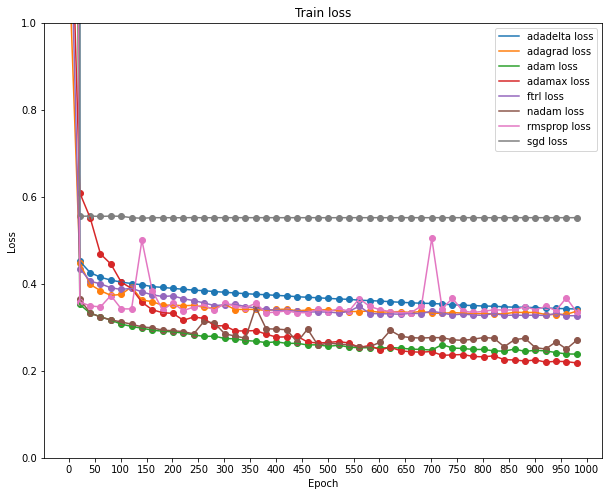

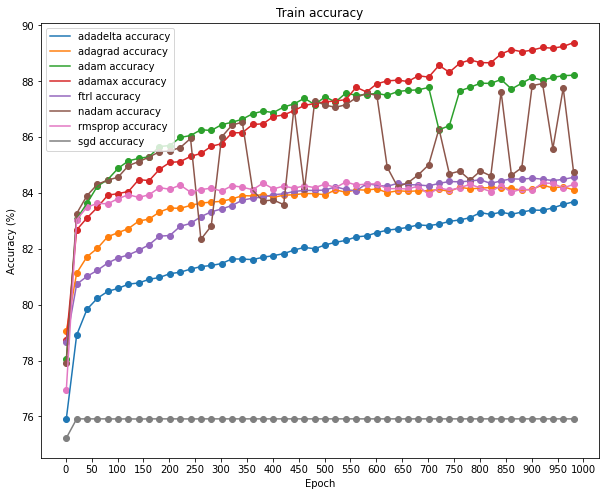

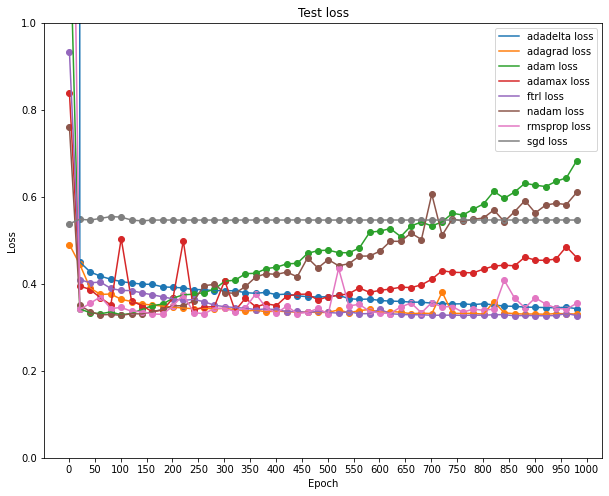

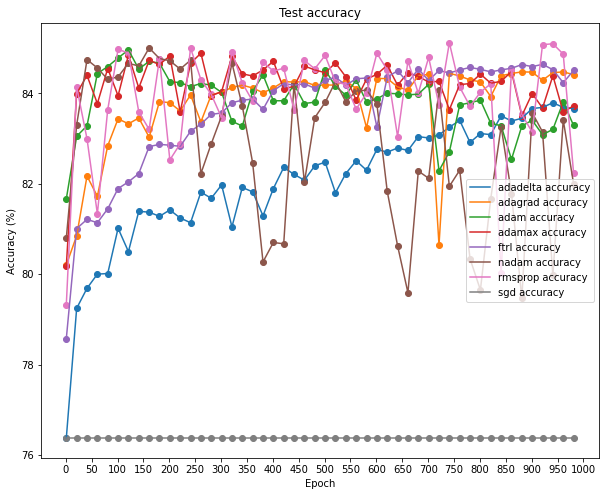

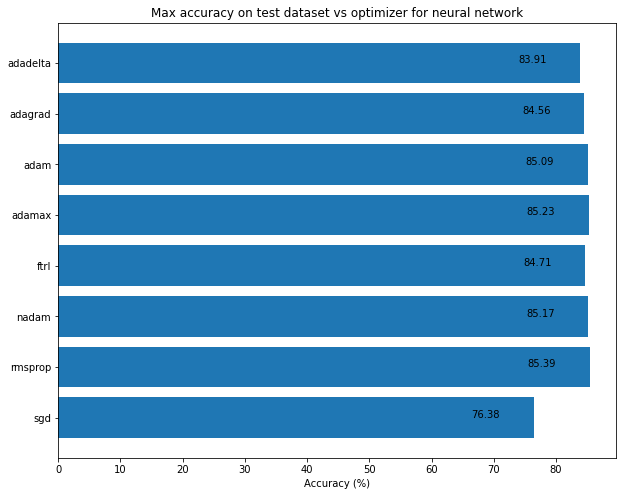

In [29]:
#Show non-regularized results results
results = pickle.load(open("neural_network_results.pkl","rb" ))
create_nn_plots(20)

#### Regularized-neural-network-optimizers

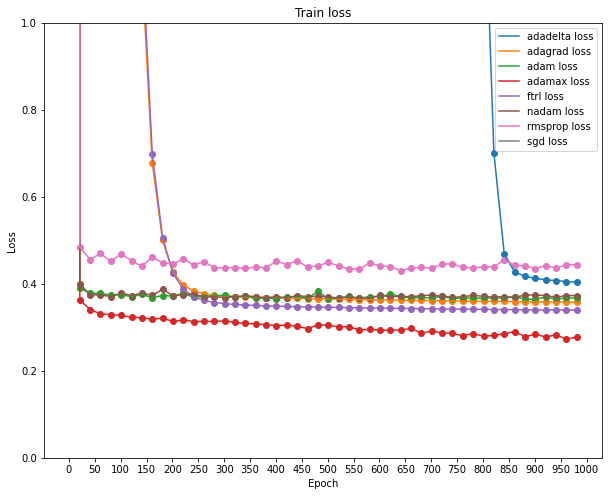

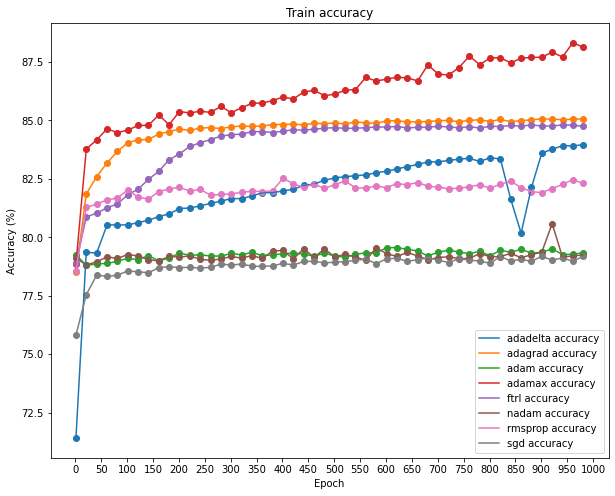

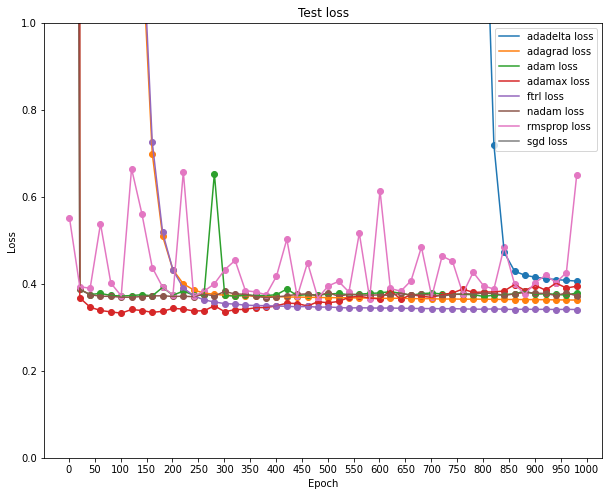

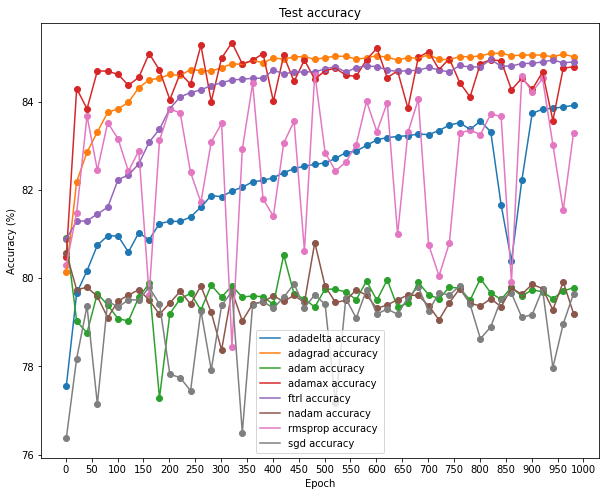

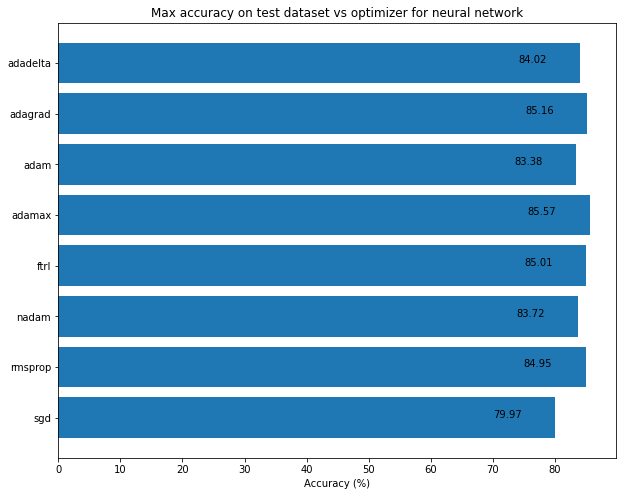

In [30]:
#Show regularized results results
results = pickle.load(open("neural_network_reg_results.pkl","rb" ))
create_nn_plots(20)

From the above graphs, we can see each optimizer behaves extremely differently - currently, we only see every 20th item from each dataset for sake of minimizing data points. From the bar chart at the bottom, we see most algorithms performing extremely well at >=84% accuracy.

An interesting note is how some optimizers approach 90% accuracy on the training set, perhaps a sign of overfitting - we see models in the regularized group that don't approach this 90% marker as much as the models from the non-regularized group.

### Adam-optimizer
Now, let's look at the results from using just the 'adam' optimizer to see other metrics.

In [31]:
model = create_model('adam')
model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Epoch 1/100
458/458 [==============================] - 1s 1ms/step - loss: 5.5631 - accuracy: 0.7802 - val_loss: 1.3140 - val_accuracy: 0.7900
Epoch 2/100
458/458 [==============================] - 0s 986us/step - loss: 1.7393 - accuracy: 0.7937 - val_loss: 2.3510 - val_accuracy: 0.7986
Epoch 3/100
458/458 [==============================] - 0s 954us/step - loss: 1.5514 - accuracy: 0.8038 - val_loss: 1.7722 - val_accuracy: 0.8032
Epoch 4/100
458/458 [==============================] - 0s 958us/step - loss: 1.3410 - accuracy: 0.8119 - val_loss: 0.6998 - val_accuracy: 0.8216
Epoch 5/100
458/458 [==============================] - 0s 940us/step - loss: 1.2342 - accuracy: 0.8145 - val_loss: 0.4706 - val_accuracy: 0.8305
Epoch 6/100
458/458 [==============================] - 0s 950us/step - loss: 0.7319 - accuracy: 0.8176 - val_loss: 0.6941 - val_accuracy: 0.8133
Epoch 7/100
458/458 [==============================] - 0s 962us/step - loss: 0.8759 - accuracy: 0.8207 - val_loss: 0.5458 - val_accu

458/458 [==============================] - 0s 1ms/step - loss: 0.3250 - accuracy: 0.8400 - val_loss: 0.3394 - val_accuracy: 0.8410
Epoch 58/100
458/458 [==============================] - 0s 1ms/step - loss: 0.3260 - accuracy: 0.8399 - val_loss: 0.3398 - val_accuracy: 0.8425
Epoch 59/100
458/458 [==============================] - 0s 983us/step - loss: 0.3255 - accuracy: 0.8397 - val_loss: 0.3338 - val_accuracy: 0.8428
Epoch 60/100
458/458 [==============================] - 0s 1ms/step - loss: 0.3255 - accuracy: 0.8403 - val_loss: 0.3410 - val_accuracy: 0.8403
Epoch 61/100
458/458 [==============================] - 0s 970us/step - loss: 0.3240 - accuracy: 0.8419 - val_loss: 0.3345 - val_accuracy: 0.8422
Epoch 62/100
458/458 [==============================] - 0s 978us/step - loss: 0.3238 - accuracy: 0.8407 - val_loss: 0.3392 - val_accuracy: 0.8373
Epoch 63/100
458/458 [==============================] - 0s 969us/step - loss: 0.3225 - accuracy: 0.8428 - val_loss: 0.3363 - val_accuracy: 0.84

#### Neural-network-accuracy

In [32]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 1ms/step - loss: 0.3327 - accuracy: 0.8454


[0.3326649069786072, 0.8454025983810425]

In [33]:
#Get numbers for AUROC curve
preds = model.predict(test_csv.to_numpy()).ravel()
nn_fpr, nn_tpr, _ = roc_curve(test_y, preds)
nn_roc_auc = auc(nn_fpr, nn_tpr)

#### Neural-network-CM

[[11931   504]
 [ 2013  1833]]


<AxesSubplot:>

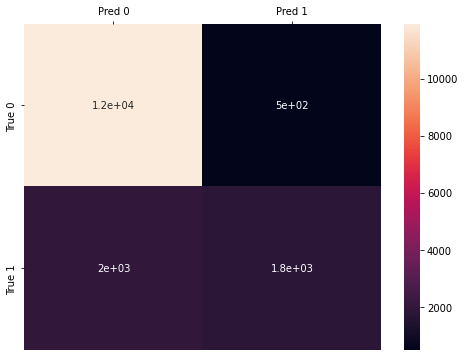

In [34]:
#Creating confusion matrix for proportion
preds = np.where(preds < 0.5, 0, 1)
create_confusion_matrix(preds, test_y)

### Neural-network-results

#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of nearly 0.85, which is excellent. Noticable improvement was seen when feature pruning was introduced (was ~0.78 accuracy).
#### Confusion Matrix
The confusion matrix shows the greatest improvement with feature pruning - before, there were <100 guesses for >50k classifications total. Now, there is a large chunk of true positives (and false positives). 

==========================================================

### Naive-bayes
#### Why I chose this algorithm
Naive bayes are great for classifying large datasets with many features. Computationally, they are significantly faster than most other algorithms. Additionally, this takes a different approach - the assumption with "naive" bayes is that all features are independent. Most other algorithms, such as the neural network, look for patterns among features and classes, but this assumes total independence of each feature from one another.
#### Pros
* Fast
* Simple to implement, fewer hyperparameters to tweak for best results
* When assumption of independence holds true, classifies better than most models

#### Cons
* Due to less hyperparameters, more rigid to results - what you get is what you get
* Anything in test data not in training data will be set to probability 0, and model will be unable to make a prediction for that class
* Assumption of indendence is rarely true

#### Improvements that could be made
* Instead of a naive bayes approach, spending time to implement a bayesian network instead where features are related to each other
* Create a generative model for missing data, so model doesn't have to guess 0 if the data is missing

In [35]:
#Load
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [36]:
from sklearn.naive_bayes import GaussianNB

#Sort into train/test sets
train_y = train_csv.pop('class').to_numpy()
train_x = train_csv.to_numpy()
test_y = test_csv.pop('class').to_numpy()
test_x = test_csv.to_numpy()

#Create Gaussian Naive Bayues, fit, get the y-scores, and show ROC curve
gnb = GaussianNB()
start = time.time()
gnb.fit(train_x, train_y)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of NB: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Runtime of NB: 00:00:00.01 (HH:MM:SS.MS)


#### NB-accuracy

In [37]:
preds = gnb.predict(test_x)
print('Accuracy: {0:.{1}f}'.format((preds == test_y).sum() / len(test_y), 4))

Accuracy: 0.7988


In [38]:
#Get ROC curve variables
nb_score = gnb.predict_proba(test_x)
nb_fpr, nb_tpr, _ = roc_curve(test_y, nb_score[:, 1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

#### NB-CM

[[11825   610]
 [ 2665  1181]]


<AxesSubplot:>

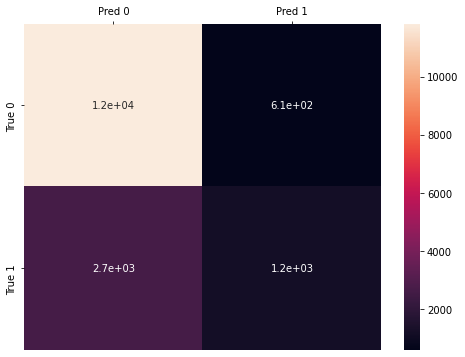

In [39]:
create_confusion_matrix(preds, test_y)

### NB-results
#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of nearly 0.80.
#### Confusion Matrix
Again, significant improvement thanks to feature pruning. The largest error seems to be with false negatives. While the neural network trains and updates, the naive bayes algorithm relies on probabilities from the training set, which don't update over time. This dataset has roughly a 75/25 split for both classes, where 75% make <=50k, and 25% make >50k. Because of this, the model is more likely to predict 0 (<=50k) instead of 1 (>50k).

==========================================================

### Support-vector-machines
#### Why I chose this algorithm
Support Vector Machiones work well when there are clear separations between classes. Additionally, SVM's are more effective in high-dimensional spaces.

#### Pros
* Effective in higher dimensions
* Great when classes are separable
* Outliers have less impact

#### Cons
* Very slow
* The more overlap classes have, the worse the performance
* Selecting hyperparameters and kernel functions can be difficult

#### Improvements that could be made
* Due to time constraints, I went with scikit's built in SVM. Given time, I'd be able to fiddle around with this more and pick the best options for this SVM
* This one is just a time constraint, but due to the time SVM's take to train, include more samples in the fitting method/using a linear kernel.

In [40]:
#Load and format data
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [41]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


#Get random sample of 20000
train_csv = train_csv.sample(n=20000)
train_y = train_csv.pop('class').to_list()
train_x = train_csv.values.tolist()

test_y = test_csv.pop('class').to_list()
test_x = test_csv.values.tolist()

#Fit SVM
start = time.time()
svm = SVC(kernel='poly', probability=True)
svm.fit(train_x,train_y)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of SVM: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Runtime of SVM: 00:00:15.76 (HH:MM:SS.MS)


#### SVM-accuracy

In [42]:
#Show accuracy
preds = svm.predict(test_x)
print('Accuracy: {0:.{1}f}'.format(accuracy_score(test_y, preds), 4))

Accuracy: 0.7850


In [43]:
#Create AUROC
svm_score = svm.predict_proba(test_x)
svm_fpr, svm_tpr, _ = roc_curve(test_y, svm_score[:, 1])
svm_roc_auc = auc(svm_fpr, svm_tpr)

#### SVM-CM

[[12432     3]
 [ 3497   349]]


<AxesSubplot:>

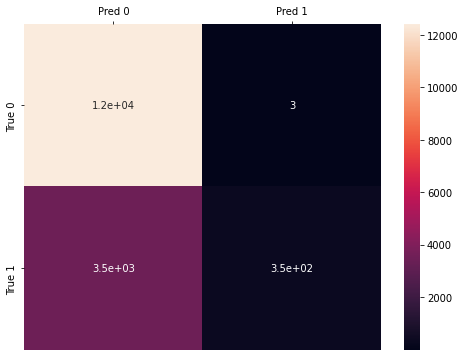

In [44]:
#Show confusion matrix
create_confusion_matrix(preds, test_y)

### SVM-results
#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of almost 0.79. Currently, only 20,000 samples are used for training due to the time it takes for this algorithm to run. I attempted to use a liner kernel on 2,000 samples overnight, and that process either froze or never finished.

#### Confusion Matrix
This confusion matrix shows most classifications leaning away from classifying as >50k. Interestingly, there are very few false positives predicted. I would like to see how this algorithm performs with a linear kernel on the entire dataset, as soon as I get my hands on a space-age computer fast enough to do that training in my lifetime.

==========================================================

### General-ensemble-classifiers
Instead of just using random forests, I wanted to take advantage of the available classifiers in scikit's ensemble library. Below, I will use the follow models:
 * AdaBoost
 * Bagging
 * ExtraTrees
 * GradientBoosting
 * RandomForest
 * HistGradientBoosting (experimental)

In [45]:
def fit_and_score(name, model):
    #Fit model
    start = time.time()
    model.fit(train_x, train_y)
    end = time.time()
    
    #Print time
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Runtime of {}: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(name, int(hours),int(minutes),seconds))
    
    #Get accuracy
    preds = model.predict(test_x)
    acc = accuracy_score(test_y, preds)
    print('Accuracy of {}: {:.{}f}'.format(name, acc, 4))
    
    #Get numbers for auroc curve
    score = model.predict_proba(test_x)
    fpr, tpr, _ = roc_curve(test_y, score[:, 1])
    roc_auc = auc(fpr, tpr)

    return acc, fpr, tpr, roc_auc
    
#Load and format data
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

In [47]:
#Create models
adaBoost = AdaBoostClassifier(n_estimators=1000)
bagging = BaggingClassifier(n_estimators=1000, n_jobs=-1, random_state=0)
extraTrees = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, criterion='entropy', random_state=0)
gradBoost = GradientBoostingClassifier(n_estimators=150, random_state=0)
randForest = RandomForestClassifier(criterion="entropy", n_estimators=150, n_jobs=-1, random_state=0)
histGrad = HistGradientBoostingClassifier(random_state=0)

#Add to list for convenience
models = []
models.append(['AdaBoost', adaBoost])
models.append(['Bagging', bagging])
models.append(['ExtraTrees', extraTrees])
models.append(['GradientBoosting', gradBoost])
models.append(['RandomForest', randForest])
models.append(['HistogramGradientBoosting', histGrad])

#### Ensembles-accuracies

In [48]:
#Loop through each model, display accuracy and save for bar chart
data = []
for n, m in models:
    acc, fpr, tpr, roc_auc = fit_and_score(n, m)
    data.append([n, acc, fpr, tpr, roc_auc])
    print()

Runtime of AdaBoost: 00:00:06.85 (HH:MM:SS.MS)
Accuracy of AdaBoost: 0.8695

Runtime of Bagging: 00:00:03.82 (HH:MM:SS.MS)
Accuracy of Bagging: 0.8441

Runtime of ExtraTrees: 00:00:02.28 (HH:MM:SS.MS)
Accuracy of ExtraTrees: 0.8390

Runtime of GradientBoosting: 00:00:01.65 (HH:MM:SS.MS)
Accuracy of GradientBoosting: 0.8689

Runtime of RandomForest: 00:00:00.45 (HH:MM:SS.MS)
Accuracy of RandomForest: 0.8501

Runtime of HistogramGradientBoosting: 00:00:00.80 (HH:MM:SS.MS)
Accuracy of HistogramGradientBoosting: 0.8715



#### Ensembles-bar-chart

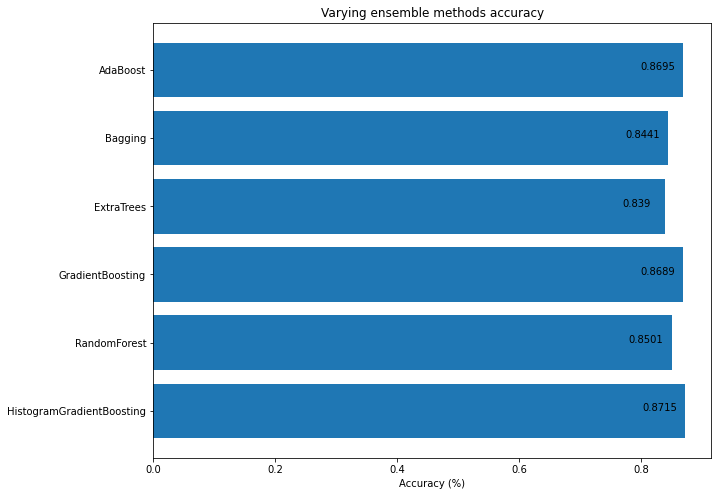

In [49]:
#Get values for bar chart
labels = [i[0] for i in data]
accs = [i[1] for i in data]

#Show accuracy for each model
y_pos = np.arange(len(accs))
fig, ax = plt.subplots(figsize=(10, 8))    
ax.barh(y_pos, accs, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy (%)')
ax.set_title('Varying ensemble methods accuracy')
for i, v in enumerate(accs):
    ax.text(v-0.07, i, str(round(v,4)))

#### Ensembles-ROC-curves

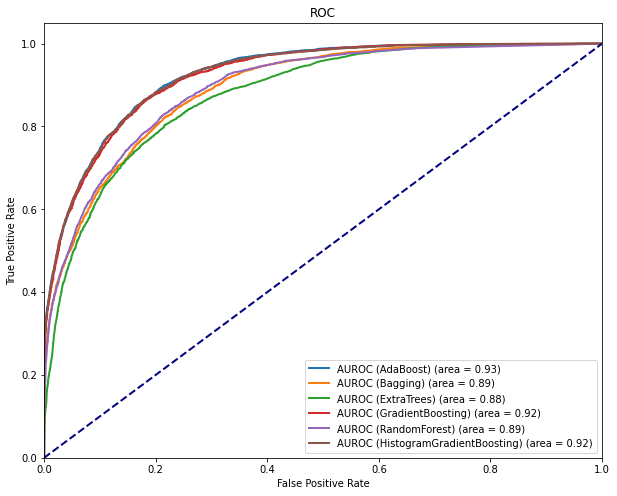

In [50]:
#Plot ROC curves
plt.figure(figsize=(10,8))
lw = 2

for i in data:
    plt.plot(i[2], i[3], lw=lw, label='AUROC ({}) (area = {})'.format(i[0], round(i[4], 2)))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

From the above bar chart and ROC curves, we see that there are several ensemble classifiers that perform better than the random forest - namely, AdaBoost, GradientBoosting, and HistogramGradientBoosting. An interesting note is that the RandomForest classifier uses bagging, whereas the three that outperformed all use boosting. Additionally, almost all of the ensembles scored better on the ROC chart than the neural network did, which is shown below

### Random-forest
#### Why I chose this algorithm
Single decision trees work well when there are clear delineations among the data. Random forests, or ensembles, work extremely well where a single decision tree would work well. Using an ensemble to find the splits among large datasets is not only fast, but excellent at fitting.
#### Pros
* Fast
* Elegant and powerful solution when working in high-dimensional data spaces
* Works well with missing/incomplete/error-prone datasets

#### Cons
* Similar to neural networks, more of a "black box" approach - not as much control over exactly what goes on inside the random forest ensemble
* Works poorly when features aren't correlated
* Multitudes of hyperparameters can wildly affect performance

#### Improvements that could be made
* Tweak hyperparameters delicately for best results

In [51]:
#Load and format data
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [52]:
train_y = train_csv.pop('class').to_list()
train_x = train_csv.values.tolist()

test_y = test_csv.pop('class').to_list()
test_x = test_csv.values.tolist()

rf = RandomForestClassifier(criterion="entropy", random_state=0)

start = time.time()
rf.fit(train_x, train_y)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of RF: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Runtime of RF: 00:00:02.40 (HH:MM:SS.MS)


#### RF-accuracy

In [53]:
preds = rf.predict(test_x)
print('Accuracy: {0:.{1}f}'.format(accuracy_score(test_y, preds), 4))

Accuracy: 0.8517


In [54]:
#Create AUROC
rf_score = rf.predict_proba(test_x)
rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_score[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

#### RF-CM

[[11540   895]
 [ 1520  2326]]


<AxesSubplot:>

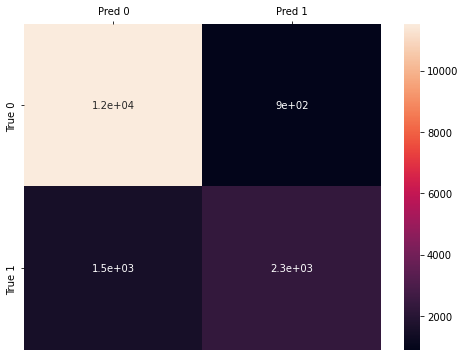

In [55]:
#Show confusion matrix
create_confusion_matrix(preds, test_y)

### RF-results
#### Evaluation
Random forest accuracy seems to be the best of these 4 models, coming in at over 0.85. Additionally, this is one of the fastest models as well, performing great among highly-correlated data.

#### Confusion Matrix
This confusion matrix shows the most accurate classifications of true positives (>50k), as well as the fewest classifications of false positives/negatives.

## ROC-curves
Displayed here are the ROC curves for each classification algorithm used above.

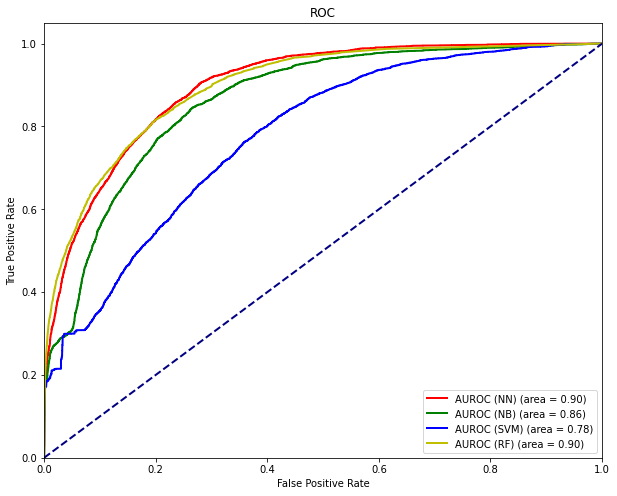

In [56]:
plt.figure(figsize=(10,8))
lw = 2

#Plot neural network
plt.plot(nn_fpr, nn_tpr, color='r',
         lw=lw, label='AUROC (NN) (area = %0.2f)' % nn_roc_auc)
#Plot naive bayes
plt.plot(nb_fpr, nb_tpr, color='g',
         lw=lw, label='AUROC (NB) (area = %0.2f)' % nb_roc_auc)
#Plot SVM
plt.plot(svm_fpr, svm_tpr, color='b',
         lw=lw, label='AUROC (SVM) (area = %0.2f)' % svm_roc_auc)
#Plot random forest
plt.plot(rf_fpr, rf_tpr, color='y',
         lw=lw, label='AUROC (RF) (area = %0.2f)' % rf_roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Above, we can see how each algorithm did, with the random forest having the greatest area under the ROC curve, followed by the neural network, the naive-bayes algorithm, and lastly with the SVM. 
* I anticipated the NN and random forest doing extremely well, as finding the common segments and patterns here would be a fitting task for both algorithms. 
* I am surprised by the naive bayes a bit - later, I will discuss how these features relate, and naive bayes assumes feature independence. 
* It's not too surprising to see the SVM not doing as well, given the time constraint - again, more time would have likely shown a better fit with the linear kernel.

==========================================================

## Segmentation

One way to segment would be to try and group people based on analysis of the above attributes
* Age - Seems to be a trend present, middle ages have higher percentages of people making >50k
* Workclass - Certain classes, such as self-empl-inc, have higher percentages of people making >50k
* Education - Higher education correlates to higher percentages of people making >50k
* Marital Status - Married people have higher percentages of people making >50k compared to data
* Occupation - Some jobs, such as managers/executives, have higher percentages of people making >50k
* Relationship - Married people have higher percentages of people making >50k
* Race - Certain races have lower percentages of people making >50k
* Sex - Men tend to have higher percentages of people making >50k
* Capital Gain - Certain splits, such as 7,000-20,000, higher percentages of people making >50k
* Native Country - Some countries have higher or lower percentages of people making >50k

Looking further at these features, several of these are related: Age, Workclass, Education, Marital Status, Occupation, Relationship, and possibly Capital Gain.
* Generally, it takes a person many years to finish a Masters or Professional Schoool, and even longer to finish a Doctoral degree (linked to higher percentages)
* Additionally, people don't often start at the manager/executive level - this takes several years
* While many younger people do get married, it is often something that takes time

Because of this, a person's age is a factor in their occupation, education, marital status, and most of what affects their income.

Given this information, we could segment certain demographics, such as married men, or executives. Let's look at a few segments from the above information.



### Manual-segmentation

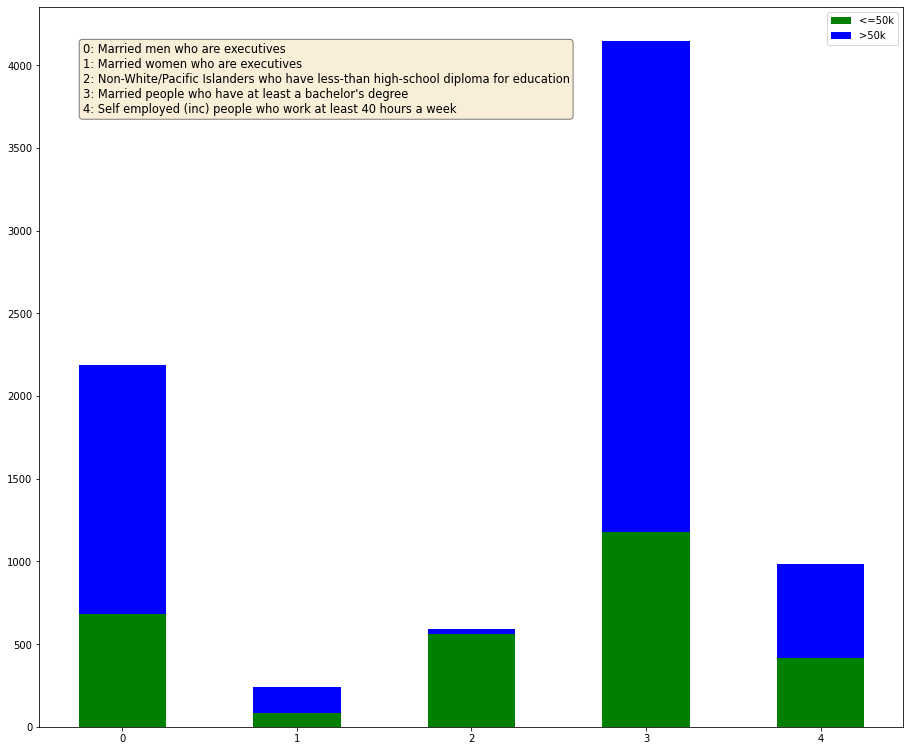

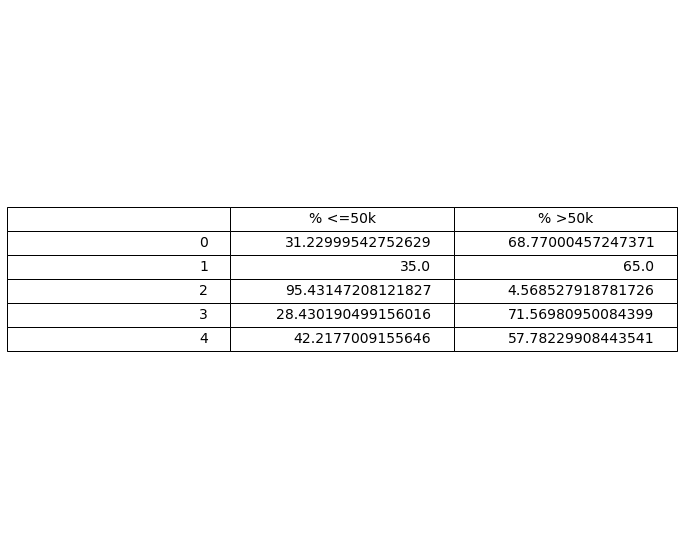

In [57]:
#Load data
train_csv, test_csv = load_datasets()

#Convert class to numerical
train_csv['class'] = pd.Categorical(train_csv['class'])
train_csv['class'] = train_csv['class'].cat.codes
ds = pd.concat([train_csv, test_csv], axis=0)
segments = []

#First segment - married men who are executives
temp = ds.loc[(ds['relationship'] == ' Husband') & (ds['occupation'] == ' Exec-managerial')]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Second segment - married women who are executives
temp = ds.loc[(ds['relationship'] == ' Wife') & (ds['occupation'] == ' Exec-managerial')]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Third segment - non-white/pacific islanders who have little education
lower_educations = [' 12th', ' 10th', ' 5th-6th', ' 1st-4th', ' Preschool' ' 7th-8th', ' 9th', ' 11th']
temp = ds.loc[(ds['race'] != ' White') & (ds['race'] != ' Asian-Pac-Islander') & (ds['education'].isin(lower_educations))]                                                                         
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Fourth segment - married people who have at least a bachelors degree
higher_educations =[' Prof-school', 'Doctorate', ' Masters', ' Bachelors']
temp = ds.loc[((ds['relationship'] == ' Husband') | (ds['relationship'] == ' Wife')) & (ds['education'].isin(higher_educations))]                                                                       
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Fifth segment - self-empl-inc who work at least 40 hours per week
temp = ds.loc[(ds['workclass'] == ' Self-emp-inc') & (ds['hours-per-week'] >= 40)]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Create bargraph
y0 = [i[0] for i in segments]
y1 = [i[1] for i in segments]
x = np.arange(len(y0))
width = 0.5
fig = plt.figure(1, figsize=(12, 10))
ax = fig.add_axes([0,0,1,1])
ax.bar(x, y0, width, color='g', label='<=50k')
ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
x = ['0: Married men who are executives', 
'1: Married women who are executives',
'2: Non-White/Pacific Islanders who have less-than high-school diploma for education',
'3: Married people who have at least a bachelor\'s degree',
'4: Self employed (inc) people who work at least 40 hours a week']

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, '\n'.join(x), transform=ax.transAxes, fontsize=11.5,
        verticalalignment='top',horizontalalignment='left', bbox=props)
ax.legend()
plt.show()

#Create table
y0_p = []
y1_p  = []
for i in range(len(y0)):
    y0_p.append((y0[i]/(y0[i]+y1[i]))*100)
    y1_p.append((y1[i]/(y0[i]+y1[i]))*100)

x = np.arange(len(x))
table_data = []
for i in range(len(y0)):
    table_data.append([x[i], y0_p[i], y1_p[i]])

cols = ['', '% <=50k', '% >50k']
g = plt.figure(2, figsize=(12, 10))
ax = g.add_subplot(1,1,1)
table = ax.table(cellText=table_data, colLabels = cols, loc='center')
table.set_fontsize(14)
table.scale(1,2)
ax.axis('off')
plt.show()

Above, we see several segments that could be made, both signficantly greater percent in the >50k class, and one for significantly less. There are more segments that could be made by hand that will give both above and below average percentages, but I will be doing something different.

### Automated-segmentation

One last approach that I will showcase for segmenting - we could instead use a brute force method, analyzing certain datasets that perform better in our training set.
A problem with a brute force method is trying to analyze all features - unfortunately, if we did that, there are 8,628,360,700,000,000 possible categories in the set of cartesian products for all features. 

If we remove certain features and focus only on a few, we get a more manageable number of categories - 6,350,400, to be exact.

Features to remove:
* Ages - as discussed above, age is reflected in many other features, which will be on this list
* Capital Gain/Capital Loss - too many items to include for this example
* Hours per week - too many items to include for this example

Below, we will save notable results - those that have >=15 matching cases, into a text file for future use. Additionally, we will only store results with either <=20% or >=30% of people in the >50k salary category.

In [58]:
train_csv, test_csv = load_datasets()
train_csv.pop('education-num')
test_csv.pop('education-num')
feat_atts = defaultdict(list)


#Workclasses
feat_atts['workclass'] = train_csv['workclass'].unique()

#Education
feat_atts['education'] = train_csv['education'].unique()

#Marital-status
feat_atts['marital-status'] = train_csv['marital-status'].unique()

#Occupation
feat_atts['occupation'] = train_csv['occupation'].unique()

#Race
feat_atts['race'] = train_csv['race'].unique()

#Sex
feat_atts['sex'] = train_csv['sex'].unique()


#Native country
feat_atts['native-country'] = train_csv['native-country'].unique()


In [59]:
import itertools
from collections import Counter
from random import shuffle

#Create cartesian product list of all possible combinations for each sublist
cart_prod = list(itertools.product(*list(feat_atts.values())))
#Shuffle (used for testing purposes, no impact on production)
shuffle(cart_prod)
#Create defaultdict which defaults to counter
cart_prod_dict = defaultdict(Counter)
#Columns used in brute force method
cols_of_importance = ['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']

In [60]:
#Convert train_csv to 0's and 1's
train_csv['class'] = pd.Categorical(train_csv['class'])
train_csv['class'] = train_csv['class'].cat.codes

def check_combinations(comb_set):
    #Count which combination currently checking
    for count, comb in enumerate(comb_set):
        #Create temporary copy of train_csv dataset
        temp = train_csv.copy(True)
        #Loop through every column specified, and narrow down the temp dataset based on current combination and specified column
        for i, col in enumerate(cols_of_importance):
            temp = temp.loc[temp[col] == comb[i]]
        
        #Count rows with class <=50k and >50k
        lte50k = len(temp.loc[temp['class'] == 0].index)
        gt50k = len(temp.loc[temp['class'] == 1].index)
        
        #Add counts to counter at specified combination
        cart_prod_dict[comb][0] += lte50k
        cart_prod_dict[comb][1] += gt50k

#This takes over 11 hours, set this boolean to true to re-store data
run_this_cell = False
if run_this_cell:
    start = time.time()
    check_combinations(cart_prod)
    end = time.time()

    with open('brute_force_results.data', 'w') as f:
        #End timer and display results in HH:MM:SS.MS
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        f.write("Runtime of brute force method: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)\n\n".format(int(hours),int(minutes),seconds))

        #Go through each result, store if significant (>= 15 cases)
        notable_results = {}
        for k, v in cart_prod_dict.items():
            if v[0] + v[1] >= 15:
                perc = v[1] / (v[0] + v[1])
                if perc <= 0.2 or perc >= 0.3:
                    notable_results[k] = [v[0], v[1], (v[1] / (v[0] + v[1])) * 100]
                    
        #Sort from highest to lowest percent
        notable_results = sorted(notable_results.items(), key=lambda x: x[1][2], reverse=True)

        #Save results of significance to file for future use
        f.write('Results sorted by descending % >50k\nKeywords are from the below columns, in order:\nWorkclass, Education, Marital-status, Occupation, Race, Sex, Country-of-origin')
        f.write('='*75)
        f.write('\n')

        for i in notable_results:
            #print("{}\n<=50k: {}, >50k: {}, % >50k: {:.2f}%\n".format(i[0], i[1][0], i[1][1], i[1][2]))
            f.write("{}\n<=50k: {}, >50k: {}, % >50k: {:.2f}%\n".format(i[0], i[1][0], i[1][1], i[1][2]))



In [61]:
data = defaultdict(str)
#Load data
with open('brute_force_results.data', 'r') as f:
    for x, line in enumerate(f):
        #First 8 lines are just header lines
        if x > 7:
            #Data works in groups of 3:
            #Line 0: the data
            #Line 1: newline
            #Line 2: the category, or the key
            if line == '\n':
                continue
            if x % 3 == 2:
                key = line.strip(' \t\n\r')
            elif x % 3 == 0:
                data[key] = line
        else:
            print(line)

#Convert key'd data from str to lists
sorted_data = {}               
for k in data.keys():
    #Load in data, replace classes as 0's and 1's
    temp = data[k].replace('\n', '').replace('<=50k', '0').replace('>50k', '1').replace('% 1', '%')[:-1].split(', ')
    #Create dictionary with keys 0, 1, and %
    temp_dict = {0: int(temp[0][temp[0].find(' ')+1:]),
                1: int(temp[1][temp[1].find(' ')+1:]),
                '%': float(temp[2][temp[2].find(' ')+1:])}
    sorted_data[k] = temp_dict

#Sort data by % >50k
sorted_data = sorted(sorted_data.items(), key=lambda x: x[1]['%'], reverse=True)

for i in sorted_data:
    print(i[0], '\n', i[1], '\n')



Runtime of brute force method: 12:43:33.08 (HH:MM:SS.MS)



Results sorted by descending % >50k

Keywords are from the below columns, in order:

Workclass, Education, Marital-status, Occupation, Race, Sex, Country-of-origin






(' Self-emp-inc', ' Prof-school', ' Married-civ-spouse', ' Prof-specialty', ' White', ' Male', ' United-States') 
 {0: 1, 1: 56, '%': 98.25} 

(' Private', ' Doctorate', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States') 
 {0: 1, 1: 15, '%': 93.75} 

(' Federal-gov', ' Some-college', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States') 
 {0: 1, 1: 14, '%': 93.33} 

(' Private', ' Masters', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States') 
 {0: 12, 1: 159, '%': 92.98} 

(' Local-gov', ' Masters', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States') 
 {0: 3, 1: 24, '%': 88.89} 

(' State-gov', ' Doctorate', ' Married-civ-spouse', ' Prof-specialty', '

In [62]:
#Get category counts
cat_counts = [0, 0]
for i in sorted_data:
    if i[1]['%'] < 20:
        cat_counts[0]+=1
    else:
        cat_counts[1]+=1

lt25p = round((cat_counts[0] / (cat_counts[0]+cat_counts[1])*100), 2)
gte25p = round((cat_counts[1] / (cat_counts[0]+cat_counts[1])*100), 2)
print('{} categories, or {}% of categories with <25% of people making >50k'.format(cat_counts[0], lt25p))
print('{} categories, or {}% of categories with over >=25% of people making >50k'.format(cat_counts[1], gte25p))
print()

#Get people counts
people_counts = [[0, 0], [0, 0]]
for i in sorted_data:
    if i[1]['%'] < 25:
        people_counts[0][0]+=i[1][0]
        people_counts[0][1]+=i[1][1]
    else:
        people_counts[1][0]+=i[1][0]
        people_counts[1][1]+=i[1][1]

lt25p = round((people_counts[0][1]/(people_counts[0][0]+people_counts[0][1])*100), 2)
gte25p = round((people_counts[1][1]/(people_counts[1][0]+people_counts[1][1])*100), 2)
print('{} people are in the "<25% making >50k" categories. Of those people, there are {}% making >50k'.format(people_counts[0][0]+people_counts[0][1], lt25p))
print('{} people are in the ">=25% making >50k" categories. Of those people, there are {}% making >50k'.format(people_counts[1][0]+people_counts[0][1], gte25p))

206 categories, or 62.61% of categories with <25% of people making >50k
123 categories, or 37.39% of categories with over >=25% of people making >50k

9989 people are in the "<25% making >50k" categories. Of those people, there are 4.49% making >50k
3964 people are in the ">=25% making >50k" categories. Of those people, there are 56.36% making >50k


From the above results, we can see some interesting trends based on the categorical data alone.
* The best performing category, with 56 out of 57 samples making >50k, are self-emp-inc, have prof-school education, are married-civ-spouse, have prof-specialty occupation, are white males, and live in the US.
* Almost every category above 40% people making >50k has 'Married-civ-spouse' for marital status.
* Workclass alone doesn't seem to be as correlated to success - the top 6 performing categories all have different workclasses. However, many poor performing categories seem to have 'Private' for the workclass. This could also be due to the workclass 'Private' being the largest reported for the 'Occupation' feature.
* Although 'White' is seen as race for most high-performers, it is also seen frequently in the average and low performers. This shows that 'White' was the largest race involved in this study.
* There doesn't appear to be many, if any, native countries other than 'United-States'. This could be due to numerical features not included in this selection, or it shows less of a correlation for notable categories.
* 2/3 of notable categories have <25% making >50k, while the last third has >=25%.

Additional statistics at the bottom of the output:
* The percent of people in the ">=25% making >50k" category is over 1200% more than those in the "<25% making 50k" category.
* The total percents for each split are extremely far from the 25/75 split, with only 4.49% in the "<25% making >50k" category making >50k, and 56.36% in the ">=25% making >50k" making >50k.